In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import sqrt, cos, sin,exp
import matplotlib
from matplotlib import cm
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
from scipy.stats import vonmises
import math
from scipy.optimize import fsolve

In [2]:
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Native skin model

Basic functions: 
* Weibull distribution 
* Second Piola Kirchhoff stress for planar deformations  

In [3]:
def weibull(lams, beta, delta, gama):
    return (beta/delta)*((lams-gama)/delta)**(beta-1)*np.exp(-((lams-gama)/delta)**beta)

def integrand(lams, lam, beta, delta, gama):
    p_lams=(beta/delta)*((lams-gama)/delta)**(beta-1)*np.exp(-((lams-gama)/delta)**beta)
    lamr = lam/lams
    return p_lams*(lamr**2-(1/lamr))

In [4]:
def PK2_native(F,param,rho_theta):
    
    # unpack parameters 
    mu0      = param[0]
    K        = param[1]
    mu_co    = param[2]
    beta_co  = param[3]
    delta_co = param[4]
    gama_co  = param[5]
    
    C=np.dot(F,F.transpose())
    J=np.sqrt(np.linalg.det(C))
    I1= np.trace(C)
    cinv = np.linalg.inv(C)
    Sp=np.zeros([3,3])
    Id=np.eye(3)
    # W Isochoric
    Siso=2*(J**(-2./3.))*(mu0)*(Id-(1./3.)*I1*(cinv))

    # W Volume
    #Wvol = p*(J-1)
    p = 2*K*(J-1)
    Svol = p*J*cinv

    ntheta = len(rho_theta)
    for i in range(ntheta):
        thetai = rho_theta[i,0]
        rhoi = rho_theta[i,1]
        a0 = np.array([math.cos(thetai),math.sin(thetai),0])
        d_a0 = np.outer(a0,a0)
        lam = np.sqrt(np.dot(a0,np.dot(C,a0)))
        if lam>gama_co:
            int_po = quad(integrand, gama_co, lam, args=(lam,beta_co,delta_co,gama_co))
        else:
            int_po = [0]
        int_val_co = int_po[0]
        Sfiber_co = 2*mu_co*(1.0/(lam**2))*int_val_co*rhoi  
        
        Sp += Sfiber_co*d_a0
        
    # this is compressible 
    S = Siso + Svol + Sp
    # this is incompressible 
    Svol33 = -Siso[2,2]
    S = Siso + Svol33*Id + Sp
    return S

Specification of parameters for native skin. 

Plots of fiber orientation and waviness distribution for native skin. The orientation distribution is a $\pi$-periodic von Mises distribution, whereas the waviness follows a Weibul distribution. 

Plots of mechanical response of native skin under biaxial deformation 

In [5]:
# Parameters for isotropic part
# The values for these parameters are based on the paper 
# The regional-dependent biaxial behavior of young and aged mouse skin. Acta biomaterialia,2020.
mu0=0.001 # [MPa]
K = 0.1 # [MPa]

## Parameters for Co 
# this is a guess, but estimated based on the parameters k1 in 
# The regional-dependent biaxial behavior of young and aged mouse skin. Acta biomaterialia,2020.
mu_co=0.5 # [MPa]
# given the guesses for the other parameters, the orientation distribution parameters were manually
# adjusted to achieve stresses and shapes representative of the experimental data in Part 1
beta_co=2.6 
delta_co=0.15
gama_co=1.03

# fiber density for different angles theta from von mises distribution 
# this is based on: 
# The regional-dependent biaxial behavior of young and aged mouse skin. Acta biomaterialia,2020.
kappa = 1.25
theta0 = 0.0 
ntheta = 51
rho_theta = np.zeros((ntheta,2))
for i in range(ntheta):
    theta = -np.pi/2+2*i/(ntheta-1)*np.pi/2.0
    rho_theta[i,0] = theta
    #print(theta)
    # scipy stats is centered around 0
    VM = vonmises.pdf(2*theta, kappa)
    rho_theta[i,1] = VM

lams_ls = np.linspace(0.7,1.4,100)
plams_Co = np.zeros(100)

# Different delta values with a maximum stretch of 2
for i in range(100):
    if lams_ls[i]<gama_co:
        plams_Co[i]=0
    else:
        plams_Co[i]=weibull(lams_ls[i], beta_co, delta_co, gama_co)


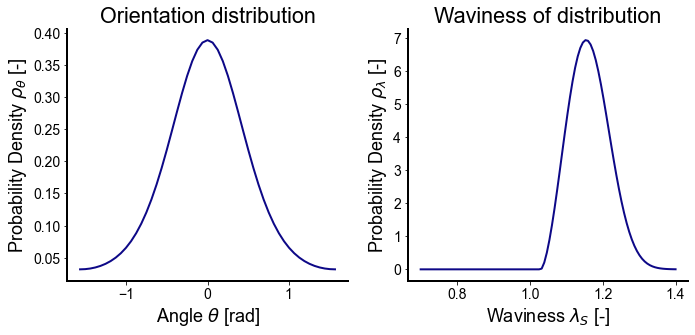

In [6]:
# plot the initial orientation distribution
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
plasma_ls = np.linspace(0,1,3)
plasma_colors = [ cm.plasma(x) for x in plasma_ls ]
fig, axs = plt.subplots(1, 2,figsize=(10,5))
#axs[0].plot(np.linspace(-np.pi/2,np.pi/2,51),rho_theta[:,1],color='royalblue',linewidth=2)
axs[0].plot(np.linspace(-np.pi/2,np.pi/2,51),rho_theta[:,1],color=plasma_colors[0],linewidth=2)
axs[0].set_title('Orientation distribution')
axs[0].set_xlabel(r'Angle $\theta$ [rad]')
axs[0].set_ylabel('Probability Density '+r'$\rho_\theta$ [-]')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
#axs[1].plot(lams_ls,plams_Co,color='royalblue',linewidth=2,label='Co')
axs[1].plot(lams_ls,plams_Co,color=plasma_colors[0],linewidth=2,label='Co')
axs[1].set_title(r'Waviness of distribution')
axs[1].set_xlabel('Waviness '+r'$\lambda$'r'$_{S}$ [-]')
axs[1].set_ylabel('Probability Density '+r'$\rho_\lambda$ [-]')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
plt.tight_layout()
#plt.savefig('waviness_orientation_distributions.png',dpi=300)

In [7]:
# plot the initial orientation distribution
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

Manual fit to mechanical data from Part 1. 

In [8]:
nlam = 20
lamx_ls = np.linspace(1,1.1,nlam)
lamy_ls = np.linspace(1,1.2,nlam)
# in cases that multiple combinations are needed
ncases = 1
S_ls = np.zeros((ncases**2,nlam,2))
beta_cases = np.linspace(2.6,2.6,ncases)
delta_cases = np.linspace(0.15,0.15,ncases)
for ci in range(ncases):
    for cj in range(ncases):
        beta = beta_cases[ci]
        delta = delta_cases[cj]
        params = np.array([mu0,K,mu_co,beta,delta,gama_co])
        for i in range(nlam):
            lamx = lamx_ls[i]
            lamy = lamy_ls[i]
            F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
            S = PK2_native(F,params,rho_theta)
            S_ls[ci*ncases+cj,i,0] = S[0,0]
            S_ls[ci*ncases+cj,i,1] = S[1,1]

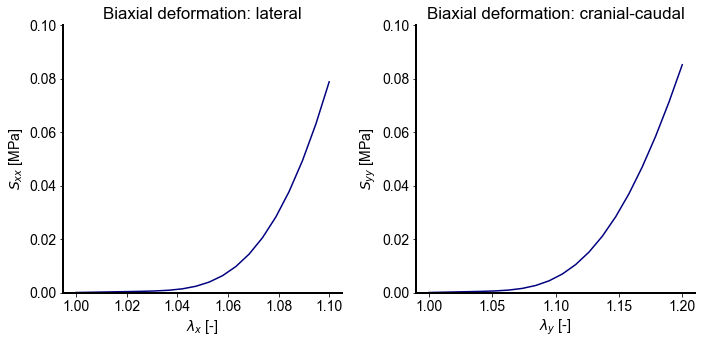

In [9]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
color_ls = np.linspace(0,1,ncases**2)
colors1 = [ cm.jet(x) for x in color_ls ]
colors2 = [ cm.winter(x) for x in color_ls ]

for i in range(ncases):
    for j in range(ncases):
        axs[0].plot(lamx_ls,S_ls[i*ncases+j,:,0],color=colors1[i*ncases+j],label='beta=%.2f, delta=%.2f'%(beta_cases[i],delta_cases[j]))
        axs[1].plot(lamy_ls,S_ls[i*ncases+j,:,1],color=colors1[i*ncases+j],label='beta=%.2f, delta=%.2f'%(beta_cases[i],delta_cases[j]))
#axs[0].legend(loc=(1,0))
axs[0].set_title('Biaxial deformation: lateral')
axs[0].set_ylabel(r'$S_{xx}$ [MPa]')
axs[0].set_xlabel(r'$\lambda_x$ [-]')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].set_ylim((0,0.10))
##
axs[1].set_title('Biaxial deformation: cranial-caudal')
axs[1].set_ylabel(r'$S_{yy}$ [MPa]')
axs[1].set_xlabel(r'$\lambda_y$ [-]')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].set_ylim((0,0.10))
plt.tight_layout()

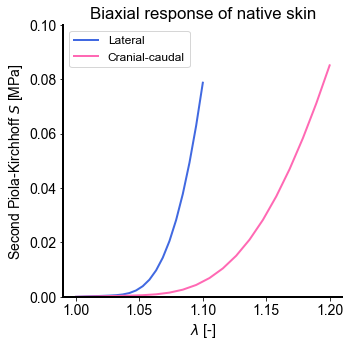

In [10]:
# Plot in a single plot 
fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(lamx_ls,S_ls[0,:,0],color='royalblue',label='Lateral',linewidth=2)
axs.plot(lamy_ls,S_ls[0,:,1],color='hotpink',label='Cranial-caudal',linewidth=2)
axs.set_title('Biaxial response of native skin')
axs.set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
axs.set_xlabel(r'$\lambda$ [-]')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_linewidth(2)
axs.spines['left'].set_linewidth(2)
axs.set_ylim((0,0.10))
axs.legend(loc=2)


## Two-state denaturation model 

Details in the manuscript. Briefly, collagen goes from the native state to a denatured state with rate k of Arrhenius type. The denatured collagen has different material properties with respect to the native skin, and it is viscoelastic. 



### Mechanical behavior for the two-state model


In [11]:
def integrand2(lams, lam, beta, delta, gama):
    p_lams=(beta/delta)*((lams-gama)/delta)**(beta-1)*np.exp(-((lams-gama)/delta)**beta)
    lamr = lam/lams
    return p_lams*(2*lamr**2+(1/lamr))

In [12]:
def PK2_twostate(F,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,dt):
    # F: deformation gradient 
    # param_Co: parameters native collagen 
    # param_Cd: parameters denatured collagen 
    # rho_theta: array with angles and weight of the orientation distribution per angle 
    # Co_theta: concentration of native collagen in each theta 
    # Cd_theta: concentration of denatured collagen in each theta 
    # I4e_theta: internal variable needed for the viscoelastic branch 
    # dt: time step, needed because we need to integrate the viscoelastic branch 
    
    # unpack parameters 
    # isotropic matrix
    mu0      = param_Co[0]
    K        = param_Co[1]
    # native collagen 
    mu_co    = param_Co[2]
    beta_co  = param_Co[3]
    delta_co = param_Co[4]
    gama_co  = param_Co[5]
    # denatured collagen 
    mu_cd    = param_Cd[0]
    beta_cd  = param_Cd[1]
    delta_cd = param_Cd[2]
    gama_cd  = param_Cd[3]
    # beta controls the viscosity branch relative to equilibrium branch
    beta_visc= param_Cd[4]
    # tau controls the time scale of relaxation 
    tau_visc = param_Cd[5]
    
    C=np.dot(F,F.transpose())
    J=np.sqrt(np.linalg.det(C))
    I1= np.trace(C)
    cinv = np.linalg.inv(C)
    Sp=np.zeros([3,3])
    Id=np.eye(3)
    # W Isochoric
    Siso=2*(J**(-2./3.))*(mu0)*(Id-(1./3.)*I1*(cinv))

    # W Volume
    #Wvol = p*(J-1)
    p = 2*K*(J-1)
    Svol = p*J*cinv

    ntheta = len(rho_theta)
    I4v_theta = np.ones((ntheta))
    for i in range(ntheta):
        thetai = rho_theta[i,0]
        rhoi = rho_theta[i,1]
        a0 = np.array([math.cos(thetai),math.sin(thetai),0])
        d_a0 = np.outer(a0,a0)
        lam = np.sqrt(np.dot(a0,np.dot(C,a0)))
        # integrate the stress contribution from native collagen 
        if lam>gama_co:
            int_po = quad(integrand, gama_co, lam, args=(lam,beta_co,delta_co,gama_co))
        else:
            int_po = [0]
        # integrate the equilibrium contribution from denatured collagen 
        if lam>gama_cd:
            int_pd_eq = quad(integrand, gama_cd, lam, args=(lam,beta_cd,delta_cd,gama_cd))
        else:
            int_pd_eq = [0]
        # update the internal variable
        # first calculate updated elastic strain 
        lame_n = lam/np.sqrt(I4v_theta_n[i])
        # evaluate the integrals
        if lame_n>gama_cd:
            int_pd_aux1 = quad(integrand, gama_cd, lame_n, args=(lame_n,beta_cd,delta_cd,gama_cd))
            int_pd_aux2 = quad(integrand2, gama_cd, lame_n, args=(lame_n,beta_cd,delta_cd,gama_cd))
        else:
            int_pd_aux1 = [0]
            int_pd_aux2 = [0]
        dPsif = 2*beta_visc*mu_cd*(1.0/(lame_n**2))*int_pd_aux1[0]
        d2Psif = -2*mu_cd*beta_visc/lame_n**4*int_pd_aux1[0]+mu_cd*beta_visc/lame_n**4*int_pd_aux2[0]
        if np.abs(d2Psif*lame_n**2 + dPsif)>0:
            I4edot = ((-1.0/tau_visc)*dPsif*lame_n**2)/(d2Psif*lame_n**2 + dPsif)
        else:
            I4edot = 0
        if (d2Psif*lame_n**2 + dPsif)<0:
            print('negative I4edot denominator, check')
        # new elastic strain 
        lame = lame_n + dt*I4edot
        # update the viscoelastic internal variable 
        I4v_theta[i] = (lam/lame)**2

        # stress with the new elastic stretch 
        Sfiber_co = 2*mu_co*(1.0/(lam**2))*int_po[0]*rhoi*Co_theta[i]  
        Sfiber_cd_eq = 2*mu_cd*(1.0/(lam**2))*int_pd_eq[0]*rhoi*Cd_theta[i]  
        Sfiber_cd_visc = 2*beta_visc*mu_cd*(1.0/(lame**2))*int_pd_aux1[0]*rhoi*Cd_theta[i]*lame**2/lam**2  
        
        Sp += (Sfiber_co + Sfiber_cd_eq + Sfiber_cd_visc)*d_a0
        
    # this is compressible 
    S = Siso + Svol + Sp
    # this is incompressible 
    Svol33 = -Siso[2,2]
    S = Siso + Svol33*Id + Sp
    return S, I4v_theta

In [13]:
# some quick check 
nlam = 20
lamx_ls = np.linspace(1,1.1,nlam)
lamy_ls = np.linspace(1,1.2,nlam)
lamx_ls2 = np.linspace(1.1,1,nlam)
lamy_ls2 = np.linspace(1.2,1,nlam)
S2state_ls = np.zeros((nlam*2,2))
param_Co = np.array([mu0,K,mu_co,beta,delta,gama_co])
# parameters for the denatured collagen 
# denatured collagen 
mu_cd    = mu_co*0.003
beta_cd  = beta_co
delta_cd = delta_co
gama_cd  = gama_co*0.70
# beta controls the viscosity branch relative to equilibrium branch
beta_visc= 10
# tau controls the time scale of relaxation 
tau_visc = 50 # [s]
param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_visc,tau_visc])
# since it is viscoelastic we can do loading unloading
nsteps = 2*nlam
dt = 1 # [s]
# concentration of the two types of collagen, do half and half 
Co_theta = 0.5*np.ones((len(rho_theta)))
Cd_theta = 0.5*np.ones((len(rho_theta)))
# initial condition
I4v_theta = np.ones((len(rho_theta)))
# time integration 
for i in range(nsteps):
    if i<nlam:
        lamx = lamx_ls[i]
        lamy = lamy_ls[i]
    else:
        lamx = lamx_ls2[i-nlam]
        lamy = lamy_ls2[i-nlam]
    F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
    # note, I4v_theta from previous time is passed, and update is an output, no pass by reference
    S,I4vnew = PK2_twostate(F,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta,dt)
    I4v_theta = I4vnew
    S2state_ls[i,0] = S[0,0]
    S2state_ls[i,1] = S[1,1]

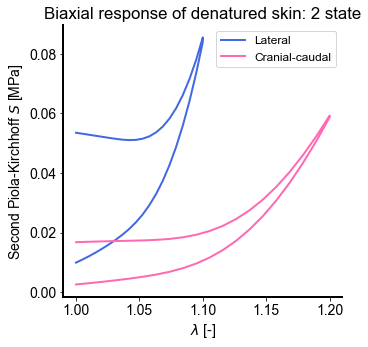

In [14]:
# Plot in a single plot 
fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(np.hstack([lamx_ls,lamx_ls2]),S2state_ls[:,0],color='royalblue',label='Lateral',linewidth=2)
axs.plot(np.hstack([lamy_ls,lamy_ls2]),S2state_ls[:,1],color='hotpink',label='Cranial-caudal',linewidth=2)
#axs.plot(lamx_ls,S2state_ls[:nlam,0],color='royalblue',label='Lateral',linewidth=2)
#axs.plot(lamy_ls,S2state_ls[:nlam,1],color='hotpink',label='Cranial-caudal',linewidth=2)
axs.set_title('Biaxial response of denatured skin: 2 state')
axs.set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
axs.set_xlabel(r'$\lambda$ [-]')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_linewidth(2)
axs.spines['left'].set_linewidth(2)
#axs.set_ylim((0,0.20))
axs.legend(loc=1)

In [15]:
## For Figure 1 show the shift in the waviness distribution and keep the same orientation 
lams_ls = np.linspace(0.7,1.4,100)
plams_Cd = np.zeros(100)

# Different delta values with a maximum stretch of 2
for i in range(100):
    if lams_ls[i]<gama_cd:
        plams_Cd[i]=0
    else:
        plams_Cd[i]=weibull(lams_ls[i], beta_cd, delta_cd, gama_cd)

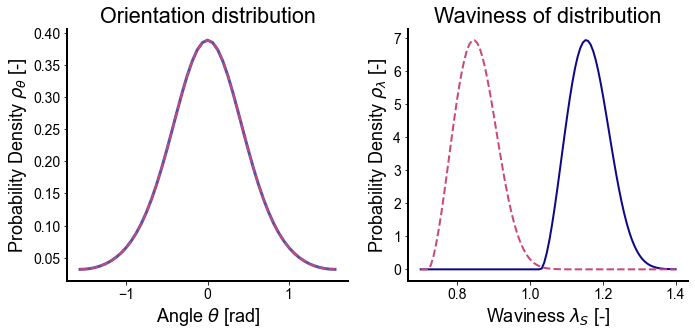

In [16]:
# plot the initial orientation distribution
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
plasma_ls = np.linspace(0,1,3)
plasma_colors = [ cm.plasma(x) for x in plasma_ls ]
fig, axs = plt.subplots(1, 2,figsize=(10,5))
#axs[0].plot(np.linspace(-np.pi/2,np.pi/2,51),rho_theta[:,1],color='royalblue',linewidth=2)
axs[0].plot(np.linspace(-np.pi/2,np.pi/2,51),rho_theta[:,1],color=plasma_colors[0],linewidth=3,alpha=0.7)
axs[0].plot(np.linspace(-np.pi/2,np.pi/2,51),rho_theta[:,1],color=plasma_colors[1],linewidth=2,linestyle='--')
axs[0].set_title('Orientation distribution')
axs[0].set_xlabel(r'Angle $\theta$ [rad]')
axs[0].set_ylabel('Probability Density '+r'$\rho_\theta$ [-]')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
#axs[1].plot(lams_ls,plams_Co,color='royalblue',linewidth=2,label='Co')
axs[1].plot(lams_ls,plams_Co,color=plasma_colors[0],linewidth=2,label='Co')
axs[1].plot(lams_ls,plams_Cd,color=plasma_colors[1],linewidth=2,label='Cd',linestyle='--')
axs[1].set_title(r'Waviness of distribution')
axs[1].set_xlabel('Waviness '+r'$\lambda$'r'$_{S}$ [-]')
axs[1].set_ylabel('Probability Density '+r'$\rho_\lambda$ [-]')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig('waviness_orientation_2state.png',dpi=300)

### Denaturation kinetics for the two-state model



In [17]:
# Arrhenius equation, with the following parameters from 
# Chen, Wright and Humphrey: Heat-induced changes in the mechanics of a collagenous tissue
Ea = 3.57e5 # J/mol 
A = 1e53
## 
R = 8.3145 # [J/mol/K]

def k_d(T):
    return A*np.exp(-Ea/R/T)

In [18]:
## analytical solution can be used to determine the Cc max or the time at which the peak occurs 
def Co_closed(t,kd):
    return np.exp(-kd*t)
def Cd_closed(t,kd):
    return 1-np.exp(-kd*t)

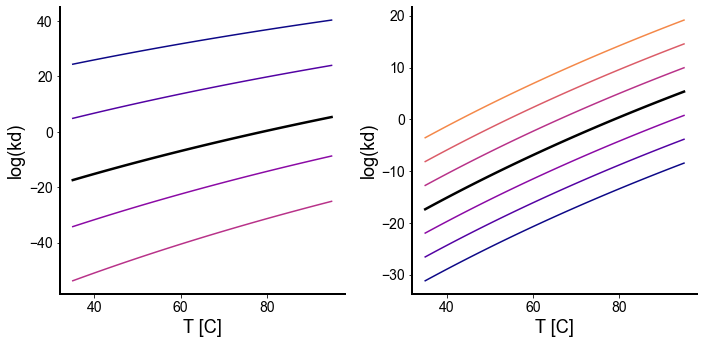

In [19]:
# Plot just to show the rate depends on temperature
fig, axs = plt.subplots(1, 2,figsize=(10,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
color_ls = np.linspace(0,1,8)
colors = [ cm.plasma(x) for x in color_ls ]

#matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
Tls = 273+np.linspace(35,95,50)
axs[0].plot(Tls-273,np.log(k_d(Tls)),color='black',linewidth=2.5)
axs[1].plot(Tls-273,np.log(k_d(Tls)),color='black',linewidth=2.5)
# change the activation energy 
Ea_list = [2.5e5,3e5,4e5,4.5e5]
for i in range(4):
    Ea = Ea_list[i]
    axs[0].plot(Tls-273,np.log(k_d(Tls)),color=colors[i])
Ea = 3.57e5
# change in the max rate
A_list = [1e47,1e49,1e51,1e55,1e57,1e59]
for i in range(6):
    A = A_list[i]
    axs[1].plot(Tls-273,np.log(k_d(Tls)),color=colors[i])
A = 1e53
#plt.title('Reaction rate for denaturation as a function of T')
axs[0].set_xlabel('T [C]')
axs[0].set_ylabel('log(kd)')
#axs[0].set_yticks([0,5e4])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[1].set_xlabel('T [C]')
axs[1].set_ylabel('log(kd)')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig('kinetics2statep1.png')

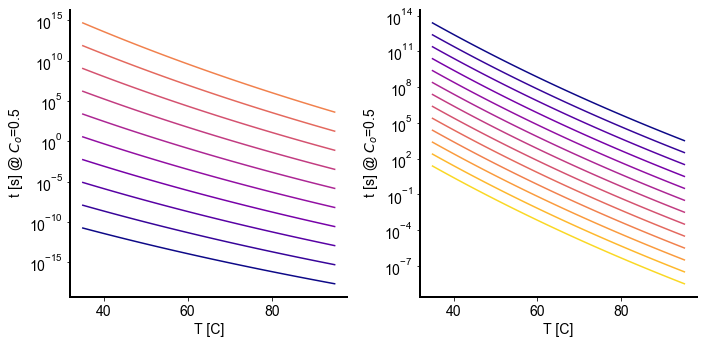

In [24]:
## Another useful thing to look at is the time it takes to reach 0.5 of Co as we change parameters 
# and as a function of temperature 
def time_c05(kd):
    # (-kd*t) = log(0.5)
    return -np.log(0.5)/kd

# Plot just to show the rate depends on temperature
fig, axs = plt.subplots(1, 2,figsize=(10,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
color_ls = np.linspace(0,1,14)
colors = [ cm.plasma(x) for x in color_ls ]

#matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
Tls = 273+np.linspace(35,95,50)
#axs[0].plot(Tls-273,time_c05(k_d(Tls)),color='black',linewidth=2.5)
#axs[1].plot(Tls-273,time_c05(k_d(Tls)),color='black',linewidth=2.5)
# change the activation energy 
#Ea_list = [2.5e5,3e5,4e5,4.5e5]
Ea_list = np.linspace(2.5e5,4.5e5,13)
for i in range(10):
    Ea = Ea_list[i]
    axs[0].plot(Tls-273,time_c05(k_d(Tls)),color=colors[i])
Ea = 3.57e5
# change in the max rate
A_list = [1e47,1e48,1e49,1e50,1e51,1e52,1e53,1e54,1e55,1e56,1e57,1e58,1e59]
for i in range(13):
    A = A_list[i]
    axs[1].plot(Tls-273,time_c05(k_d(Tls)),color=colors[i])
A = 1e53
#plt.title('Reaction rate for denaturation as a function of T')
axs[0].set_xlabel('T [C]')
axs[0].set_ylabel(r' t [s] @ $C_o$=0.5 ')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
#axs[0].set_yticks([0,5e4])
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[1].set_xlabel('T [C]')
axs[1].set_ylabel(r' t [s] @ $C_o$=0.5')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig('twostate_param_kinetics.png',dpi=300)

In [25]:
## PLOT denaturation over time for the given temperatures 

nT = 4
T_vec_K = 273+np.array([37,55,75,95])
# variables to store integration
nsteps = 50000
Co = np.ones((nsteps,nT))
Cd = np.zeros((nsteps,nT))
time = np.zeros((nsteps))
dt = 0.005
for Ti in range(nT):
    T = T_vec_K[Ti]
    for step in range(nsteps-1):
        Co[step+1,Ti] = Co[step,Ti] - dt*k_d(T)*Co[step,Ti]
        Cd[step+1,Ti] = Cd[step,Ti] + dt*k_d(T)*Co[step,Ti]
        time[step+1] = time[step]+dt

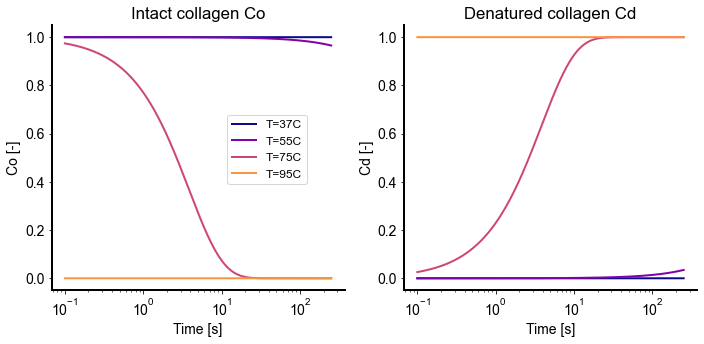

In [30]:
color_ls = np.linspace(0,1,5)
colors = [ cm.plasma(x) for x in color_ls ]
#print(colors)
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(10,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
#matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
skip = 20
for Ti in range(nT):
    axs[0].plot(time[skip:],Co[skip:,Ti],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273),linewidth=2)
    axs[1].plot(time[skip:],Cd[skip:,Ti],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273),linewidth=2)
axs[0].legend(loc=(0.6,0.4))
axs[0].set_title('Intact collagen Co')
axs[0].set_ylabel('Co [-]')
axs[0].set_xlabel('Time [s]')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_xscale('log')
#axs[1].legend(loc=(0.05,0.45))
axs[1].set_title('Denatured collagen Cd')
axs[1].set_ylabel('Cd [-]')
axs[1].set_xlabel('Time [s]')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xscale('log')
plt.tight_layout()
plt.savefig('kinetics2state.png',dpi=300)

## Three-state model 

Two reactions, from native to coiled to damaged. No viscoelastic behavior. 

In [31]:
def PK2_threestate(F,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta):
    # F: deformation gradient 
    # param_Co: parameters native collagen 
    # param_Cc: parameters coiled collagen 
    # param_Cb: parameters damaged collagen 
    # rho_theta: array with angles and weight of the orientation distribution per angle 
    # Co_theta: concentration of native collagen in each theta 
    # Cc_theta: concentration of coiled collagen in each theta 
    # Cb_theta: concentration of damaged collagen in each theta 
    
    # unpack parameters 
    # isotropic matrix
    mu0      = param_Co[0]
    K        = param_Co[1]
    # native collagen 
    mu_co    = param_Co[2]
    beta_co  = param_Co[3]
    delta_co = param_Co[4]
    gama_co  = param_Co[5]
    # coiled collagen 
    mu_cc    = param_Cc[0]
    beta_cc  = param_Cc[1]
    delta_cc = param_Cc[2]
    gama_cc  = param_Cc[3]
    # damaged collagen 
    mu_cb    = param_Cb[0]
    beta_cb  = param_Cb[1]
    delta_cb = param_Cb[2]
    gama_cb  = param_Cb[3]
    
    C=np.dot(F,F.transpose())
    J=np.sqrt(np.linalg.det(C))
    I1= np.trace(C)
    cinv = np.linalg.inv(C)
    Sp=np.zeros([3,3])
    Id=np.eye(3)
    # W Isochoric
    Siso=2*(J**(-2./3.))*(mu0)*(Id-(1./3.)*I1*(cinv))

    # W Volume
    #Wvol = p*(J-1)
    p = 2*K*(J-1)
    Svol = p*J*cinv

    ntheta = len(rho_theta)
    for i in range(ntheta):
        thetai = rho_theta[i,0]
        rhoi = rho_theta[i,1]
        a0 = np.array([math.cos(thetai),math.sin(thetai),0])
        d_a0 = np.outer(a0,a0)
        lam = np.sqrt(np.dot(a0,np.dot(C,a0)))
        # integrate the stress contribution from native collagen 
        if lam>gama_co:
            int_po = quad(integrand, gama_co, lam, args=(lam,beta_co,delta_co,gama_co))
        else:
            int_po = [0]
        # integrate the coiled collagen contribution
        if lam>gama_cc:
            int_pc = quad(integrand, gama_cc, lam, args=(lam,beta_cc,delta_cc,gama_cc))
        else:
            int_pc = [0]
        # integrate the damaged collagen contribution
        if lam>gama_cb:
            int_pb = quad(integrand, gama_cb, lam, args=(lam,beta_cb,delta_cb,gama_cb))
        else:
            int_pb = [0]
        # stress
        Sfiber_co = 2*mu_co*(1.0/(lam**2))*int_po[0]*rhoi*Co_theta[i]  
        Sfiber_cc = 2*mu_cc*(1.0/(lam**2))*int_pc[0]*rhoi*Cc_theta[i]  
        Sfiber_cb = 2*mu_cb*(1.0/(lam**2))*int_pb[0]*rhoi*Cb_theta[i]  
        
        Sp += (Sfiber_co + Sfiber_cc + Sfiber_cb)*d_a0
        
    # this is compressible 
    S = Siso + Svol + Sp
    # this is incompressible 
    Svol33 = -Siso[2,2]
    S = Siso + Svol33*Id + Sp
    return S

In [32]:
## quick check 

# coiled collagen 
mu_cc    = mu_co*0.03
beta_cc  = beta_co
delta_cc = delta_co
gama_cc  = gama_co*0.7
param_Cc = np.array([mu_cc,beta_cc,delta_cc,gama_cc])

# damaged collagen 
mu_cb    = mu_co*0.003
beta_cb  = beta_co
delta_cb = delta_co
gama_cb  = gama_co*0.7
param_Cb = np.array([mu_cb,beta_cb,delta_cb,gama_cb])

Co_theta = 0.33*np.ones((len(rho_theta)))
Cc_theta = 0.33*np.ones((len(rho_theta)))
Cb_theta = 0.33*np.ones((len(rho_theta)))

nlam = 20
lamx_ls = np.linspace(1,1.1,nlam)
lamy_ls = np.linspace(1,1.2,nlam)
# in cases that multiple combinations are needed
S3state_ls = np.zeros((nlam,2))
for i in range(nlam):
    lamx = lamx_ls[i]
    lamy = lamy_ls[i]
    F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
    S = PK2_threestate(F,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
    S3state_ls[i,0] = S[0,0]
    S3state_ls[i,1] = S[1,1]

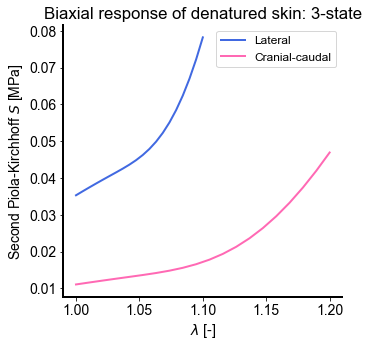

In [33]:
fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(lamx_ls,S3state_ls[:,0],color='royalblue',label='Lateral',linewidth=2)
axs.plot(lamy_ls,S3state_ls[:,1],color='hotpink',label='Cranial-caudal',linewidth=2)
axs.set_title('Biaxial response of denatured skin: 3-state')
axs.set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
axs.set_xlabel(r'$\lambda$ [-]')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_linewidth(2)
axs.spines['left'].set_linewidth(2)
#axs.set_ylim((0,0.20))
axs.legend(loc=1)

### Kinetics of denaturation for the three-state model

In [34]:
# keep the same parameters as before for the coiling
Eac = 3.57e5 # J/mol 
Ac = 1e53 # 1/s

# for damaging collagen the rate needs to increase slower 
# for now pick some values
Eab = 130000 # J/mol 
Ab = np.exp(40)

R = 8.3145 # [J/mol/K]

def k_c(T):
    return Ac*np.exp(-Eac/R/T)


def k_b(T):
    return Ab*np.exp(-Eab/R/T)

In [35]:
## analytical solution can be used to determine the Cc max or the time at which the peak occurs 
def Co_closed(t,k1):
    return np.exp(-k1*t)
def Cc_closed(t,k1,k2):
    alpha = k1/(k2-k1)
    A = -k1 
    beta = -alpha
    B = -k2
    return alpha*np.exp(A*t)+beta*np.exp(B*t)
def Cb_closed(t,k1,k2): 
    alpha = k1/(k2-k1)
    A = -k1 
    beta = -alpha
    B = -k2
    gamma = k2*alpha/A
    delta = k2*beta/B
    return gamma*np.exp(A*t)+delta*np.exp(B*t)+1
## from analytical solution, the time at which the peak of Cc occurs 
def t_Ccmax_closed(k1,k2):
    tmax = (np.log(k1)-np.log(k2))/(k1-k2)
    return tmax

def Ccmax_closed(k1,k2):
    tmax = (np.log(k1)-np.log(k2))/(k1-k2)
    Ccmax = Cc_closed(tmax,k1,k2)
    return Ccmax

def Ccmax_closed2(k1,k2):
    tmax = (np.log(k1)-np.log(k2))/(k1-k2)
    alpha = k1/(k2-k1)
    beta = k2/(k2-k1)
    Ccmax = alpha*((k1/k2)**(alpha)-(k1/k2)**beta)
    return Ccmax

def Ccmax_solve(k2,k1=0.26,val=0.5):
    tmax = (np.log(k1)-np.log(k2))/(k1-k2)
    alpha = k1/(k2-k1)
    beta = k2/(k2-k1)
    Ccmax = alpha*((k1/k2)**(alpha)-(k1/k2)**beta)
    return Ccmax-val


In [36]:
# rate again, slightly different function 
def k_c_param(T,Eac,Ac):
    return Ac*np.exp(-Eac/R/T)

def k_b_param(T,Eab,Ab):
    return Ab*np.exp(-Eab/R/T)

# also needed the derivative of the Ccmax with respect to the temperature 
def dCcmaxdT(T,Eac,Ac,Eab,Ab):
    k1 = k_c_param(T,Eac,Ac)
    k2 = k_b_param(T,Eab,Ab)
    dk1dT = Eac/R/T**2*Ac*np.exp(-Eac/R/T)
    dk2dT = Eab/R/T**2*Ab*np.exp(-Eab/R/T)
    tmax = (np.log(k1)-np.log(k2))/(k1-k2)
    alpha = k1/(k2-k1)
    A = -k1 
    beta = -alpha
    B = -k2
    gamma = k2*alpha/A
    delta = k2*beta/B
    # derivatives
    dalphadk1 = 1.0/(k2-k1) + k1/(k2-k1)**2
    ddeltadk1 = -k2*dalphadk1/B
    dgammadk1 = k2*dalphadk1/A + k2*alpha/A**2
    dalphadk2 = -k1/(k2-k1)**2
    dgammadk2 = alpha/A + k2*dalphadk2/A
    dbetadk2 = k1/(k2-k1)**2
    ddeltadk2 = beta/B + k2*dbetadk2/B + k2*beta/B**2
    dCccloseddt = A*gamma*np.exp(A*tmax)+B*delta*np.exp(B*tmax)
    dCccloseddk1 = -tmax*gamma*np.exp(A*tmax)+ dgammadk1*np.exp(A*tmax) + ddeltadk1*np.exp(B*tmax) 
    dCccloseddk2 = dgammadk2*np.exp(A*tmax)+ddeltadk2*np.exp(B*tmax)-tmax*delta*np.exp(B*tmax)
    # chain rule for tmax
    dtmaxdk1 = (1.0/k1)/(k1-k2) - (np.log(k1)-np.log(k2))/(k1-k2)**2
    dtmaxdk2 = (-1.0/k2)/(k1-k2) + (np.log(k1)-np.log(k2))/(k1-k2)**2
    dtmaxdT = dtmaxdk1*dk1dT + dtmaxdk2*dk2dT
    # final chain rule 
    dCccloseddT = dCccloseddt*dtmaxdT + dCccloseddk1*dk1dT + dCccloseddk2*dk2dT
    return dCccloseddT

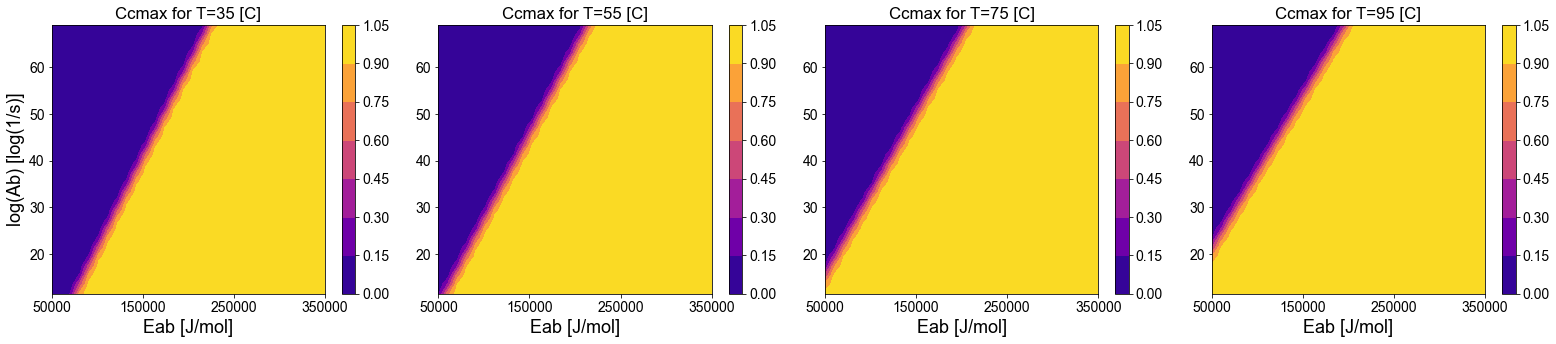

In [309]:
## Contour might be better 
fig, axs = plt.subplots(1, 4,figsize=(22,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
Eab_ls = np.linspace(0.5e5,3.5e5,30)
logAb_ls = np.linspace(np.log(1e5),np.log(1e30),30)
X, Y = np.meshgrid(Eab_ls, logAb_ls)
cs0 = axs[0].contourf(X, Y, Ccmax_closed2(k_c_param(273+35,3.57e5,1e53),k_b_param(273+35,X,np.exp(Y))), cmap=plt.cm.plasma)
cs1 = axs[1].contourf(X, Y, Ccmax_closed2(k_c_param(273+55,3.57e5,1e53),k_b_param(273+55,X,np.exp(Y))), cmap=plt.cm.plasma)
cs2 = axs[2].contourf(X, Y, Ccmax_closed2(k_c_param(273+75,3.57e5,1e53),k_b_param(273+75,X,np.exp(Y))), cmap=plt.cm.plasma)
#axs[2].scatter([130000],[40],s=40,color='white')
cs3 = axs[3].contourf(X, Y, Ccmax_closed2(k_c_param(273+95,3.57e5,1e53),k_b_param(273+95,X,np.exp(Y))), cmap=plt.cm.plasma)
axs[0].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[1].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[2].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[3].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[0].set_title('Ccmax for T=35 [C]')
axs[1].set_title('Ccmax for T=55 [C]')
axs[2].set_title('Ccmax for T=75 [C]')
axs[3].set_title('Ccmax for T=95 [C]')
axs[0].set_xlabel('Eab [J/mol]')
axs[1].set_xlabel('Eab [J/mol]')
axs[2].set_xlabel('Eab [J/mol]')
axs[3].set_xlabel('Eab [J/mol]')
axs[0].set_ylabel('log(Ab) [log(1/s)]')
cbar0 = fig.colorbar(cs0,ax=axs[0])
cbar1 = fig.colorbar(cs1,ax=axs[1])
cbar2 = fig.colorbar(cs2,ax=axs[2])
cbar3 = fig.colorbar(cs3,ax=axs[3])
plt.tight_layout()
#plt.savefig('Ccmax_contoursv2.png')

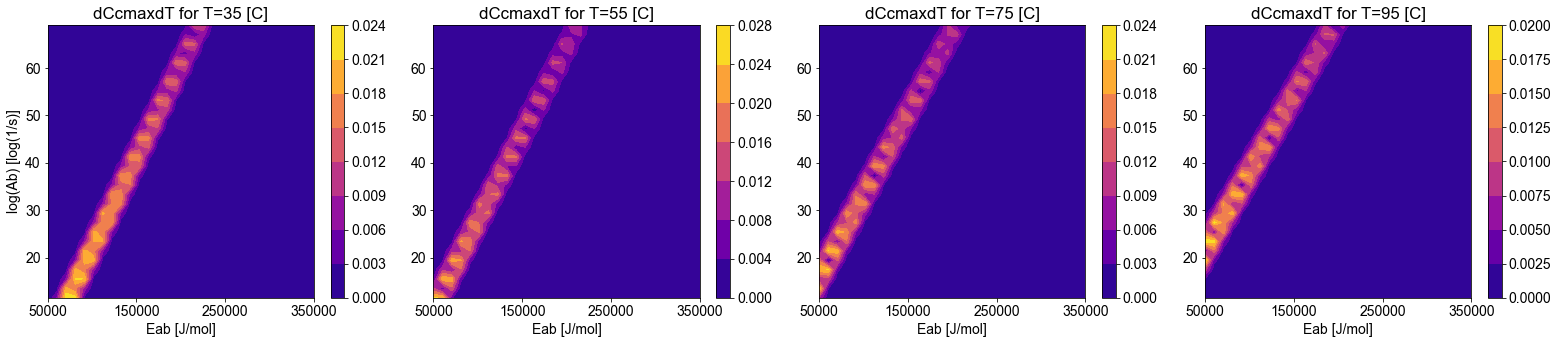

In [26]:
## Contour might be better 
# These contours show the derivatrive of the peak with respect to the temperature for
# different temperatures and for different combination of the parameters Eab and Ab
fig, axs = plt.subplots(1, 4,figsize=(22,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
Eab_ls = np.linspace(0.5e5,3.5e5,30)
logAb_ls = np.linspace(np.log(1e5),np.log(1e30),30)
X, Y = np.meshgrid(Eab_ls, logAb_ls)
cs0 = axs[0].contourf(X, Y, np.abs(dCcmaxdT(273+35,3.57e5,1e53,X,np.exp(Y))), cmap=plt.cm.plasma)
cs1 = axs[1].contourf(X, Y, np.abs(dCcmaxdT(273+55,3.57e5,1e53,X,np.exp(Y))), cmap=plt.cm.plasma)
cs2 = axs[2].contourf(X, Y, np.abs(dCcmaxdT(273+75,3.57e5,1e53,X,np.exp(Y))), cmap=plt.cm.plasma)
cs3 = axs[3].contourf(X, Y, np.abs(dCcmaxdT(273+95,3.57e5,1e53,X,np.exp(Y))), cmap=plt.cm.plasma)
axs[0].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[1].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[2].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[3].set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs[0].set_title('dCcmaxdT for T=35 [C]')
axs[1].set_title('dCcmaxdT for T=55 [C]')
axs[2].set_title('dCcmaxdT for T=75 [C]')
axs[3].set_title('dCcmaxdT for T=95 [C]')
axs[0].set_xlabel('Eab [J/mol]')
axs[1].set_xlabel('Eab [J/mol]')
axs[2].set_xlabel('Eab [J/mol]')
axs[3].set_xlabel('Eab [J/mol]')
axs[0].set_ylabel('log(Ab) [log(1/s)]')
cbar0 = fig.colorbar(cs0,ax=axs[0])
cbar1 = fig.colorbar(cs1,ax=axs[1])
cbar2 = fig.colorbar(cs2,ax=axs[2])
cbar3 = fig.colorbar(cs3,ax=axs[3])
plt.tight_layout()
#plt.savefig('useless2.png')

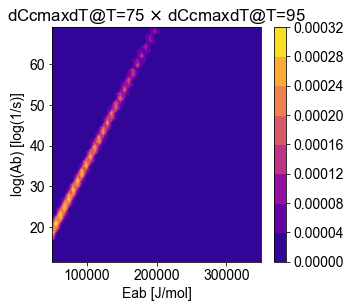

In [28]:
# This contour shows the region of the parameter space in which the peak Ccmax is 0<Ccmax<1 for 75<T<95
# in other words, outside of the region identified in this plot, the solution is trivial, either Cmax is almost 0
# or it is almost 1. We know from experiments that the force at T=95 is greater than at T=75, so we know 
# that we cannot have Ccmax->1 for T=75. Is the force maximum at T=95? We dont know that. 
fig, axs = plt.subplots(1, 1,figsize=(5,4.5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
Eab_ls = np.linspace(0.5e5,3.5e5,50)
logAb_ls = np.linspace(np.log(1e5),np.log(1e30),50)
X, Y = np.meshgrid(Eab_ls, logAb_ls)
cs=axs.contourf(X, Y,np.abs(dCcmaxdT(273+75,3.57e5,1e53,X,np.exp(Y))*dCcmaxdT(273+95,3.57e5,1e53,X,np.exp(Y))),cmap=plt.cm.plasma)
cbar = fig.colorbar(cs,ax=axs)
axs.set_title(r'dCcmaxdT@T=75 $\times$ dCcmaxdT@T=95')
axs.set_xlabel('Eab [J/mol]')
axs.set_ylabel('log(Ab) [log(1/s)]')
plt.tight_layout()
#plt.savefig('nontrivial_parameters_for_Ccmax.png')

In [67]:
## It is helpful to solve for the kb at T=75 that gives us Ccmax=0.5 
kb_sol=fsolve(Ccmax_solve,[0.15],args=(k_c(75+273),0.5))
print('kb solution')
print(kb_sol)
# check
print(Ccmax_solve(kb_sol,k_c(75+273),0.5))
print(Ccmax_closed(k_c_param(273+75,3.57e5,1e53),kb_sol))

## It is helpful to solve for the kb at T=75 that gives us Ccmax=0.75 
kb_sol0=fsolve(Ccmax_solve,[0.05],args=(k_c(75+273),0.75))
print('kb solution 0')
print(kb_sol0)
# check
print(Ccmax_solve(kb_sol0,k_c(75+273),0.75))
print(Ccmax_closed(k_c_param(273+75,3.57e5,1e53),kb_sol0))

## It is helpful to solve for the kb at T=75 that gives us Ccmax=0.8
kb_sol1=fsolve(Ccmax_solve,[0.001],args=(k_c(75+273),0.8))
print('kb solution 1')
print(kb_sol1)
# check
print(Ccmax_solve(kb_sol1,k_c(75+273),0.8))
print(Ccmax_closed(k_c_param(273+75,3.57e5,1e53),kb_sol1))

## It is helpful to solve for the kb at T=75 that gives us Ccmax=0.85
kb_sol2=fsolve(Ccmax_solve,[0.001],args=(k_c(75+273),0.85))
print('kb solution 2')
print(kb_sol2)
# check
print(Ccmax_solve(kb_sol2,k_c(75+273),0.85))
print(Ccmax_closed(k_c_param(273+75,3.57e5,1e53),kb_sol2))

## It is helpful to solve for the kb at T=75 that gives us Ccmax=0.25
kb_solm1=fsolve(Ccmax_solve,[0.15],args=(k_c(75+273),0.25))
print('kb solution m1')
print(kb_solm1)
# check
print(Ccmax_solve(kb_solm1,k_c(75+273),0.25))
print(Ccmax_closed(k_c_param(273+75,3.57e5,1e53),kb_solm1))


kb solution
[0.13023308]
[-7.77156117e-16]
[0.5]
kb solution 0
[0.03102136]
[-1.11022302e-16]
[0.75]
kb solution 1
[0.02132211]
[8.8817842e-16]
[0.8]
kb solution 2
[0.01358475]
[0.]
[0.85]
kb solution m1
[0.52093232]
[0.]
[0.25]


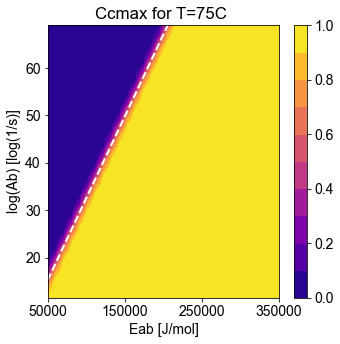

In [66]:
## CONTOUR with some lines overlaid 
## Contour might be better 
fig, axs = plt.subplots(1, 1,figsize=(5,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
Eab_ls = np.linspace(0.5e5,3.5e5,30)
logAb_ls = np.linspace(np.log(1e5),np.log(1e30),30)
X, Y = np.meshgrid(Eab_ls, logAb_ls)
cs0 = axs.contourf(X, Y, Ccmax_closed2(k_c_param(273+75,3.57e5,1e53),k_b_param(273+75,X,np.exp(Y))), cmap=plt.cm.plasma,levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs.plot(Eab_ls,np.log(kb_sol)+Eab_ls/R/(75+273),color='white',linestyle='--',linewidth=2)
#axs.plot(Eab_ls,np.log(kb_sol0)+Eab_ls/R/(75+273),color=[0.5,0.5,0.5],linewidth=2)
#axs.plot(Eab_ls,np.log(kb_sol1)+Eab_ls/R/(75+273),color=[0.5,0.5,0.5],linewidth=2)
axs.set_ylim([np.log(1e5),np.log(1e30)])
axs.set_xticks([0.5e5,1.5e5,2.5e5,3.5e5])
axs.set_title('Ccmax for T=75C ')
axs.set_xlabel('Eab [J/mol]')
axs.set_ylabel('log(Ab) [log(1/s)]')
cbar0 = fig.colorbar(cs0,ax=axs)
plt.tight_layout()
plt.savefig('Ccmax_T75.png',dpi=300)

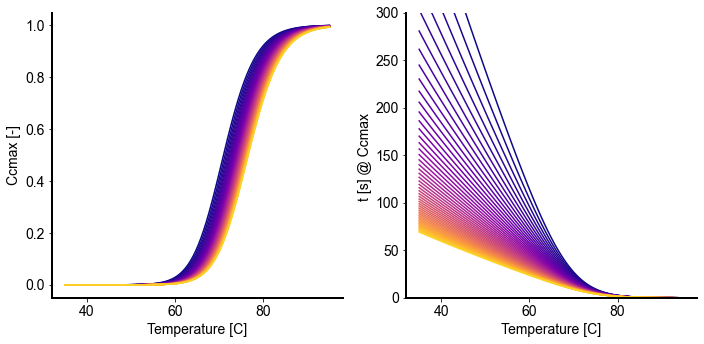

In [72]:
# Plots that help visualize what happens when Eab, Ab change... 
color_ls = np.linspace(0,1,55)
colors = [ cm.plasma(x) for x in color_ls ]
T_ls = 273+np.linspace(35,95,100)
fig, axs = plt.subplots(1, 2,figsize=(10,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
#matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
# from ksol to ksol 
kbsol_ls = np.linspace(kb_sol0,0.23,50)
for i in range(50):
    axs[0].plot(T_ls-273,Ccmax_closed(k_c(T_ls),kbsol_ls[i]),color=colors[i])
#Eab = 1e5
axs[0].set_xlabel('Temperature [C]')
axs[0].set_ylabel('Ccmax [-]')
#Ab_ls = [1e5,1e10,1e15,1e20,1e25]
for i in range(50):
    axs[1].plot(T_ls-273,t_Ccmax_closed(k_c(T_ls),kbsol_ls[i]),color=colors[i])
axs[1].set_ylim([0,300])
axs[1].set_xlabel('Temperature [C]')
axs[1].set_ylabel('t [s] @ Ccmax ')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig('Ccmax_tccmax.png',dpi=300)

In [42]:
## Plots of three-state model kinetics 

nT = 4
T_vec_K = 273+np.array([37,55,75,95])
# variables to store integration
nsteps = 50000
Co = np.ones((nsteps,nT))
Cc = np.zeros((nsteps,nT))
Cb = np.zeros((nsteps,nT))
time = np.zeros((nsteps))
dt = 0.005
Eab = 0.5e5
Ab = np.exp(np.log(kb_sol1)+Eab/R/(273+75))
for Ti in range(nT):
    T = T_vec_K[Ti]
    for step in range(nsteps-1):
        Co[step+1,Ti] = Co[step,Ti] - dt*k_c(T)*Co[step,Ti]
        Cc[step+1,Ti] = Cc[step,Ti] + dt*k_c(T)*Co[step,Ti] - dt*k_b(T)*Cc[step,Ti]
        Cb[step+1,Ti] = Cb[step,Ti] + dt*k_b(T)*Cc[step,Ti]
        time[step+1] = time[step]+dt


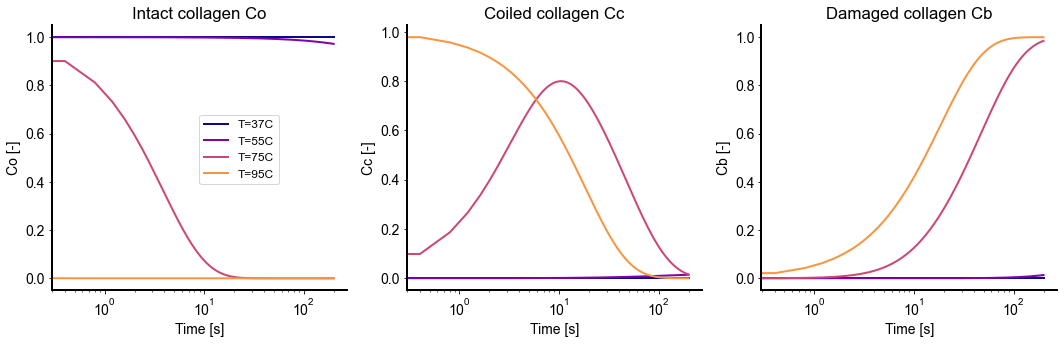

In [45]:
color_ls = np.linspace(0,1,5)
colors = [ cm.plasma(x) for x in color_ls ]


fig, axs = plt.subplots(1, 3,figsize=(15,5))
font = {'family' : 'arial',
            'weight' : 'normal',
            'size'   : 14}
matplotlib.rc('font', **font)
#matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
time = np.linspace(0,200,500)
#Ab = np.exp(40)
#Eab_ls = [60000,65000,70000,75000,80000]
#Eab_ls = [120000,125000,130000,135000,140000]
Eab_ls = [180000,185000,190000,195000,200000]
for ci in range(1):
    #Eab = Eab_ls[ci]
    #Eab = 1.5e5
    Eab = 0.5e5
    Ab = np.exp(np.log(kb_sol1)+Eab/R/(273+75))
    for Ti in range(nT):
        axs[0].plot(time,Co_closed(time,k_c_param(T_vec_K[Ti],3.57e5,1e53)),color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273),linewidth=2)
        axs[1].plot(time,Cc_closed(time,k_c_param(T_vec_K[Ti],3.57e5,1e53),k_b_param(T_vec_K[Ti],Eab,Ab)),color=colors[Ti],label='T=%0.2f'%(T_vec_K[Ti]-273),linewidth=2)
        axs[2].plot(time,Cb_closed(time,k_c_param(T_vec_K[Ti],3.57e5,1e53),k_b_param(T_vec_K[Ti],Eab,Ab)),color=colors[Ti],label='T=%0.2f'%(T_vec_K[Ti]-273),linewidth=2)
axs[0].legend(loc=(0.5,0.4))
axs[0].set_title('Intact collagen Co')
axs[0].set_ylabel('Co [-]')
axs[0].set_xlabel('Time [s]')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_xscale('log')
#
axs[1].set_title('Coiled collagen Cc')
axs[1].set_ylabel('Cc [-]')
axs[1].set_xlabel('Time [s]')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xscale('log')
#
axs[2].set_title('Damaged collagen Cb')
axs[2].set_ylabel('Cb [-]')
axs[2].set_xlabel('Time [s]')
axs[2].spines['bottom'].set_linewidth(2)
axs[2].spines['left'].set_linewidth(2)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
axs[2].set_xscale('log')
plt.tight_layout()
plt.savefig('threestate_denaturation_kinetics.png',dpi=300)



In [46]:
# Actually show Eab, Ab instead of kb
# Table 3  in the manuscript shows Eab and Ab instead of kb 
Eab = 0.5e5
Ab = np.exp(np.log(kb_sol1)+Eab/R/(273+75))
print(Ab)

[681752.82675019]


## Free shrinking 

### Two-state model

In [47]:

time_final = 3e2 # sec 
dt = 0.05 #sec 
time_steps = int(time_final/dt)
n_frames = 300
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## reminder of parameters that are free to adjust

# parameters for the denatured collagen 
# denatured collagen 
mu_cd    = mu_co*0.003
gama_cd  = gama_co*0.70
# beta controls the viscosity branch relative to equilibrium branch
beta_visc= 10
# tau controls the time scale of relaxation 
tau_visc = 50 # [s]
#
param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_visc,tau_visc])


# loop over temperature 
for i in range(nT):
    T = T_vec_K[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cd_theta = np.zeros((len(rho_theta)))
    # initialize the viscoelastic response 
    I4v_theta_n = np.ones((len(rho_theta)))
    I4v_theta = np.ones((len(rho_theta)))
    fi = 1
    kd = k_d(T)
    for ti in range(0,time_steps):
        Cd_theta_t = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta_t = Co_closed(time,kd)*np.ones((ntheta))
        time += dt 
        Cd_theta = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta = Co_closed(time,kd)*np.ones((ntheta))
        #Cddot = k_d(T)*Co_theta
        #Co_theta += -1.*dt*k_d(T)*Co_theta
        Cdnorm = Cd_theta_t/Cd_theta
        I4v_theta_n = Cdnorm*I4v_theta_n+(1-Cdnorm)
        #Cd_theta += +1.*dt*Cddot
        if time>=frame_t[fi]: 
            frame_dt = frame_t[fi]-frame_t[fi-1]
            # need to unload so that we recover zero in x and y 
            resnorm = 1
            tol = 1e-4
            iter=0
            itermax = 60
            lamxp = lamxp_vec[i,fi-1]
            lamyp = lamxp_vec[i,fi-1]
            Res = np.zeros((2))
            dRes = np.zeros((2,2))
            while iter<itermax and resnorm>tol:
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                S,I4v_new = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,frame_dt)
                Res[0] = S[0,0]
                Res[1] = S[1,1]
                lamxp += 1e-6
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                Sp, aux = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,frame_dt)
                dRes[0,0] = (Sp[0,0]-S[0,0])/1e-6
                dRes[1,0] = (Sp[1,1]-S[1,1])/1e-6
                lamxp -= 1e-6
                lamyp += 1e-6
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                Sp, aux = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,frame_dt)
                dRes[0,1] = (Sp[0,0]-S[0,0])/1e-6
                dRes[1,1] = (Sp[1,1]-S[1,1])/1e-6
                lamyp -= 1e-6
                dlamp = np.linalg.solve(dRes,Res)
                lamxp -= dlamp[0]
                lamyp -= dlamp[1]
                iter +=1
                resnorm = np.linalg.norm(Res)
            #print('iter ',iter,' resnorm ',resnorm)
            I4v_theta = I4v_new
            I4v_theta_n = I4v_new
            #print(I4v_theta)
            if iter==itermax:
                break
            lamxp_vec[i,fi] = lamxp
            lamyp_vec[i,fi] = lamyp
            fi+=1

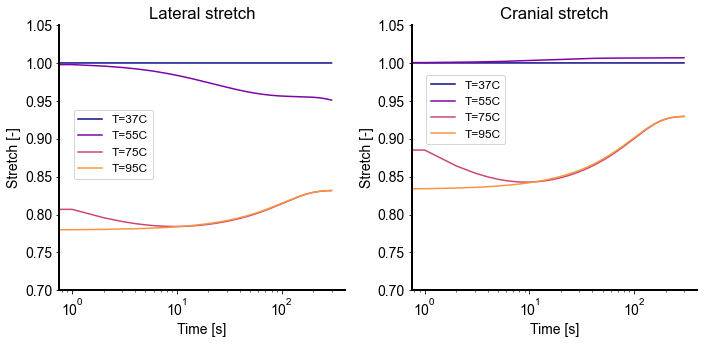

In [48]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
color_ls = np.linspace(0,1,5)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)
time_scatter = np.array([0.5e0,1e0,0.5e1,1e1,0.5e2,1e2])
for Ti in range(nT):
    axs[0].plot(frame_t[:-1],lamxp_vec[Ti,:-1],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273))
    axs[1].plot(frame_t[:-1],lamyp_vec[Ti,:-1],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273))
axs[0].set_xscale('log')
#axs[0].legend(loc=(0.6,0.4))
axs[0].set_title('Lateral stretch')
axs[0].set_ylabel('Stretch [-]')
axs[0].set_ylim((0.7,1.05))
axs[1].set_xscale('log')
axs[1].set_xlabel('Time [s]')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

#axs[1].legend(loc=(0,1))
axs[1].set_title('Cranial stretch')
axs[1].set_ylabel('Stretch [-]')
axs[1].set_ylim((0.7,1.05))
axs[0].legend(loc=(0.05,0.42))
axs[1].legend(loc=(0.05,0.55))
axs[0].set_xlabel('Time [s]')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('fig_shrink_2state.png',dpi=300)

### Three-state model 

In [49]:
time_final = 3e2 # sec 
dt = 0.1 #sec 
time_steps = int(time_final/dt)
n_frames = 100
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## Parameters that can be changed 
# coiled collagen 
mu_cc    = mu_co*0.036
beta_cc  = beta_co
delta_cc = delta_co
gama_cc  = gama_co*0.7
param_Cc = np.array([mu_cc,beta_cc,delta_cc,gama_cc])

# damaged collagen 
mu_cb    = mu_co*0.003
beta_cb  = beta_co
delta_cb = delta_co
gama_cb  = gama_co*0.7
param_Cb = np.array([mu_cb,beta_cb,delta_cb,gama_cb])

# loop over temperature 
for i in range(nT):
    T = T_vec_K[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cc_theta = np.zeros((len(rho_theta)))
    Cb_theta = np.zeros((len(rho_theta)))
    fi = 1
    for ti in range(0,time_steps):
        Co_theta = np.ones((ntheta))*Co_closed(time,k_c_param(T,3.57e5,1e53))
        Cc_theta = np.ones((ntheta))*Cc_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        Cb_theta = np.ones((ntheta))*Cb_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        time += dt
        #Ccdot = k_c(T)*Co_theta
        #Cbdot = k_b(T)*Cc_theta
        #Co_theta += -1.*dt*Ccdot
        #Cc_theta += dt*Ccdot - dt*Cbdot
        #Cb_theta += +1.*dt*Cbdot
        if time>=frame_t[fi]: 
            frame_dt = frame_t[fi]-frame_t[fi-1]
            # need to unload so that we recover zero in x and y 
            resnorm = 1
            tol = 1e-4
            iter=0
            itermax = 60
            lamxp = lamxp_vec[i,fi-1]
            lamyp = lamxp_vec[i,fi-1]
            Res = np.zeros((2))
            dRes = np.zeros((2,2))
            while iter<itermax and resnorm>tol:
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                S = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
                Res[0] = S[0,0]
                Res[1] = S[1,1]
                lamxp += 1e-6
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                Sp = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
                dRes[0,0] = (Sp[0,0]-S[0,0])/1e-6
                dRes[1,0] = (Sp[1,1]-S[1,1])/1e-6
                lamxp -= 1e-6
                lamyp += 1e-6
                Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
                Sp = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
                dRes[0,1] = (Sp[0,0]-S[0,0])/1e-6
                dRes[1,1] = (Sp[1,1]-S[1,1])/1e-6
                lamyp -= 1e-6
                dlamp = np.linalg.solve(dRes,Res)
                lamxp -= dlamp[0]
                lamyp -= dlamp[1]
                iter +=1
                resnorm = np.linalg.norm(Res)
            if iter==itermax:
                break
            lamxp_vec[i,fi] = lamxp
            lamyp_vec[i,fi] = lamyp
            fi+=1

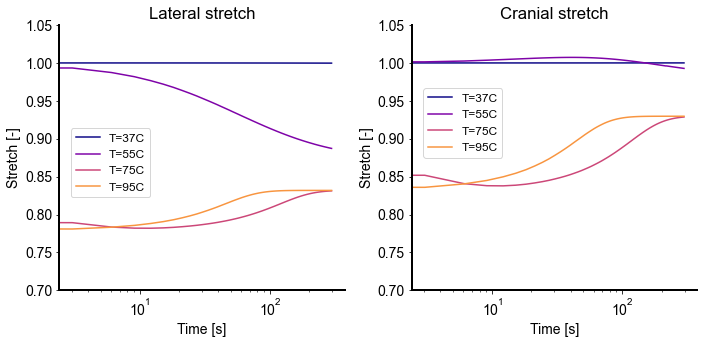

In [50]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
color_ls = np.linspace(0,1,5)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)
#time_scatter = np.array([0.5e0,1e0,0.5e1,1e1,0.5e2,1e2])
for Ti in range(nT):
    axs[0].plot(frame_t[:-1],lamxp_vec[Ti,:-1],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273))
    axs[1].plot(frame_t[:-1],lamyp_vec[Ti,:-1],color=colors[Ti],label='T=%0.0fC'%(T_vec_K[Ti]-273))
axs[0].set_xscale('log')
axs[0].legend(loc=(0.04,0.35))
axs[0].set_title('Lateral stretch')
axs[0].set_ylabel('Stretch [-]')
axs[0].set_ylim((0.7,1.05))
axs[0].set_xlabel('Time [s]')
axs[1].set_xscale('log')
#axs[1].legend(loc=(0,1))
axs[1].set_title('Cranial stretch')
axs[1].set_ylabel('Stretch [-]')
axs[1].set_ylim((0.7,1.05))
axs[1].set_xlabel('Time [s]')
axs[1].legend(loc=(0.04,0.5))
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('fig_shrink_3state.png',dpi=300)

## Isometric denaturation 

### Two-state model 

In [51]:
time_final = 3e2 # sec 
dt = 0.05 #sec 
time_steps = int(time_final/dt)
n_frames = 300
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## reminder of parameters that are free to adjust

# parameters for the denatured collagen 
# denatured collagen 
mu_cd    = mu_co*0.003
gama_cd  = gama_co*0.70
# beta controls the viscosity branch relative to equilibrium branch
beta_visc= 10
# tau controls the time scale of relaxation 
tau_visc = 50 # [s]
#
param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_visc,tau_visc])

T_vec_K_iso = [75+273,95+273]
S11_vec = np.zeros((2,n_frames))
S22_vec = np.zeros((2,n_frames))
# loop over temperature 
for i in range(2):
    T = T_vec_K_iso[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cd_theta = np.zeros((len(rho_theta)))
    # initialize the viscoelastic response 
    I4v_theta_n = np.ones((len(rho_theta)))
    I4v_theta = np.ones((len(rho_theta)))
    fi = 1
    kd = k_d(T)
    for ti in range(0,time_steps):
        Cd_theta_t = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta_t = Co_closed(time,kd)*np.ones((ntheta))
        time += dt 
        Cd_theta = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta = Co_closed(time,kd)*np.ones((ntheta))
        #Cddot = k_d(T)*Co_theta
        #Co_theta += -1.*dt*k_d(T)*Co_theta
        Cdnorm = Cd_theta_t/Cd_theta
        I4v_theta_n = Cdnorm*I4v_theta_n+(1-Cdnorm)
        #Cd_theta += +1.*dt*Cddot
        if time>=frame_t[fi]: 
            frame_dt = frame_t[fi]-frame_t[fi-1]
            # just evaluate the stress and update the viscous part 
            F = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
            S,I4v_new = PK2_twostate(F,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,frame_dt)
            #print('iter ',iter,' resnorm ',resnorm)
            I4v_theta = I4v_new
            I4v_theta_n = I4v_new
            #print(I4v_theta)
            S11_vec[i,fi] = S[0,0]
            S22_vec[i,fi] = S[1,1]
            fi+=1

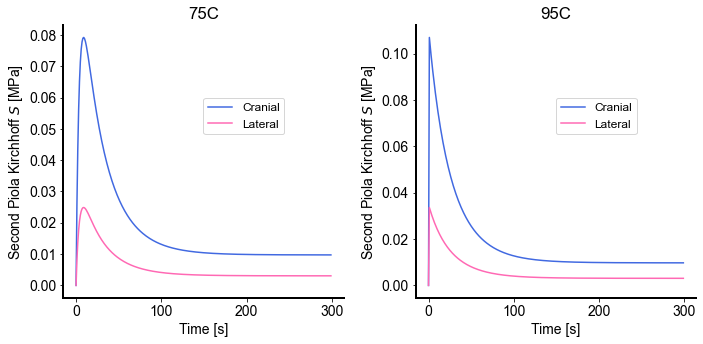

In [52]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
color_ls = np.linspace(0,1,5)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)
time_scatter = np.array([0.5e0,1e0,0.5e1,1e1,0.5e2,1e2])
axs[0].plot(frame_t[:-1],S11_vec[0,:-1],color='royalblue',label='Cranial')
axs[0].plot(frame_t[:-1],S22_vec[0,:-1],color='hotpink',label='Lateral')
axs[1].plot(frame_t[:-1],S11_vec[1,:-1],color='royalblue',label='Cranial')
axs[1].plot(frame_t[:-1],S22_vec[1,:-1],color='hotpink',label='Lateral')
#axs[0].set_xscale('log')
#axs[0].legend(loc=(0.6,0.4))
axs[0].set_title(r'75C')
axs[0].set_ylabel(r'Second Piola Kirchhoff $S$ [MPa]')
#axs[0].set_ylim((0.0,0.13))
axs[0].set_xlabel('Time [s]')
axs[0].spines['bottom'].set_linewidth(2)
axs[0].spines['left'].set_linewidth(2)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].legend(loc=(0.5,0.6))
#axs[1].set_xscale('log')
axs[1].legend(loc=(0.5,0.6))
axs[1].set_title(r'95C')
axs[1].set_ylabel(r'Second Piola Kirchhoff $S$ [MPa]')
#axs[1].set_ylim((0.0,0.13))
axs[1].set_xlabel('Time [s]')
axs[1].spines['bottom'].set_linewidth(2)
axs[1].spines['left'].set_linewidth(2)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

plt.tight_layout()
#plt.savefig('fig_isometric_2state.png',dpi=300)

In [53]:
## Same as before, but I want to check the change in phi and the change in tau_visc. 
time_final = 3e2 # sec 
dt = 0.05 #sec 
time_steps = int(time_final/dt)
n_frames = 300
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## reminder of parameters that are free to adjust

# parameters for the denatured collagen 
# denatured collagen 
mu_cd    = mu_co*0.003
gama_cd  = gama_co*0.70
# beta_visc controls the viscosity branch relative to equilibrium branch
# note that in the manuscript we changed to phi to avoid confusion with the beta of the Weibull distribution
beta_visc= 10
# tau controls the time scale of relaxation 
tau_visc = 50 # [s]
#
param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_visc,tau_visc])

T_vec_K_iso = [75+273,95+273]
S11_ps_vec = np.zeros((4,2,n_frames))
S22_ps_vec = np.zeros((4,2,n_frames))
beta_ps = [8,12,10,10]
tau_ps = [50.,50.,30.,70.]
# loop over temperature 
for ci in range(4):
    beta_ci = beta_ps[ci]
    tau_ci = tau_ps[ci]
    param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_ci,tau_ci])
    for i in range(2):
        T = T_vec_K_iso[i]
        # loop over time 
        time = 0
        # initialize the collagen concentrations in the different orientation 
        Co_theta = np.ones((len(rho_theta)))
        Cd_theta = np.zeros((len(rho_theta)))
        # initialize the viscoelastic response 
        I4v_theta_n = np.ones((len(rho_theta)))
        I4v_theta = np.ones((len(rho_theta)))
        fi = 1
        kd = k_d(T)
        for ti in range(0,time_steps):
            Cd_theta_t = Cd_closed(time,kd)*np.ones((ntheta))
            Co_theta_t = Co_closed(time,kd)*np.ones((ntheta))
            time += dt 
            Cd_theta = Cd_closed(time,kd)*np.ones((ntheta))
            Co_theta = Co_closed(time,kd)*np.ones((ntheta))
            #Cddot = k_d(T)*Co_theta
            #Co_theta += -1.*dt*k_d(T)*Co_theta
            Cdnorm = Cd_theta_t/Cd_theta
            I4v_theta_n = Cdnorm*I4v_theta_n+(1-Cdnorm)
            #Cd_theta += +1.*dt*Cddot
            if time>=frame_t[fi]: 
                frame_dt = frame_t[fi]-frame_t[fi-1]
                # just evaluate the stress and update the viscous part 
                F = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
                S,I4v_new = PK2_twostate(F,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,frame_dt)
                #print('iter ',iter,' resnorm ',resnorm)
                I4v_theta = I4v_new
                I4v_theta_n = I4v_new
                #print(I4v_theta)
                S11_ps_vec[ci,i,fi] = S[0,0]
                S22_ps_vec[ci,i,fi] = S[1,1]
                fi+=1

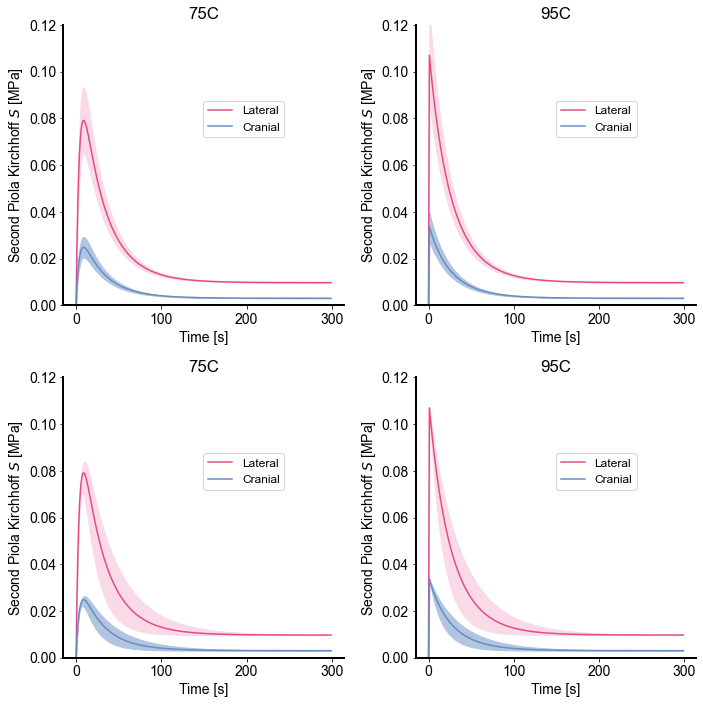

In [54]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
color_ls = np.linspace(0,1,8)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)

cp1 = [249/255,218/255,230/255]
cp2 = [231/255,73/255,136/255]
cb1 = [177/255,197/255,224/255]
cb2 = [103/255,140/255,194/255]

# plotting beta cases for the same tau 
# 75
axs[0,0].fill_between(frame_t[:-1],S11_ps_vec[0,0,:-1],S11_ps_vec[1,0,:-1],color=cp1)
axs[0,0].fill_between(frame_t[:-1],S22_ps_vec[0,0,:-1],S22_ps_vec[1,0,:-1],color=cb1)
axs[0,0].plot(frame_t[:-1],S11_vec[0,:-1],color=cp2,label='Lateral')
axs[0,0].plot(frame_t[:-1],S22_vec[0,:-1],color=cb2,label='Cranial')
# 95
axs[0,1].fill_between(frame_t[:-1],S11_ps_vec[0,1,:-1],S11_ps_vec[1,1,:-1],color=cp1)
axs[0,1].fill_between(frame_t[:-1],S22_ps_vec[0,1,:-1],S22_ps_vec[1,1,:-1],color=cb1)
axs[0,1].plot(frame_t[:-1],S11_vec[1,:-1],color=cp2,label='Lateral')
axs[0,1].plot(frame_t[:-1],S22_vec[1,:-1],color=cb2,label='Cranial')
# plotting beta cases for the same beta
# 75
axs[1,0].fill_between(frame_t[:-1],S11_ps_vec[2,0,:-1],S11_ps_vec[3,0,:-1],color=cp1)
axs[1,0].fill_between(frame_t[:-1],S22_ps_vec[2,0,:-1],S22_ps_vec[3,0,:-1],color=cb1)
axs[1,0].plot(frame_t[:-1],S11_vec[0,:-1],color=cp2,label='Lateral')
axs[1,0].plot(frame_t[:-1],S22_vec[0,:-1],color=cb2,label='Cranial')
# 95
axs[1,1].fill_between(frame_t[:-1],S11_ps_vec[2,1,:-1],S11_ps_vec[3,1,:-1],color=cp1)
axs[1,1].fill_between(frame_t[:-1],S22_ps_vec[2,1,:-1],S22_ps_vec[3,1,:-1],color=cb1)
axs[1,1].plot(frame_t[:-1],S11_vec[1,:-1],color=cp2,label='Lateral')
axs[1,1].plot(frame_t[:-1],S22_vec[1,:-1],color=cb2,label='Cranial')

#
axs[0,0].set_title(r'75C')
axs[0,1].set_title(r'95C')
axs[1,0].set_title(r'75C')
axs[1,1].set_title(r'95C')
for ai in range(2):
    for aj in range(2):
        axs[ai,aj].set_ylabel(r'Second Piola Kirchhoff $S$ [MPa]')
        axs[ai,aj].set_ylim((0.0,0.12))
        axs[ai,aj].set_xlabel('Time [s]')
        axs[ai,aj].spines['bottom'].set_linewidth(2)
        axs[ai,aj].spines['left'].set_linewidth(2)
        axs[ai,aj].spines['right'].set_visible(False)
        axs[ai,aj].spines['top'].set_visible(False)
        axs[ai,aj].legend(loc=(0.5,0.6))

plt.tight_layout()
plt.savefig('fig_isometric_ps_2state.png',dpi=300)

### Three state model 

In [55]:
time_final = 3e2 # sec 
dt = 0.1 #sec 
time_steps = int(time_final/dt)
n_frames = 300
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## Parameters that can be changed 
# coiled collagen 
mu_cc    = mu_co*0.036
beta_cc  = beta_co
delta_cc = delta_co
gama_cc  = gama_co*0.7
param_Cc = np.array([mu_cc,beta_cc,delta_cc,gama_cc])

# damaged collagen 
mu_cb    = mu_co*0.003
beta_cb  = beta_co
delta_cb = delta_co
gama_cb  = gama_co*0.7
param_Cb = np.array([mu_cb,beta_cb,delta_cb,gama_cb])
S11_vec = np.zeros((2,n_frames))
S22_vec = np.zeros((2,n_frames))
    
Eab = 0.5e5
Ab = np.exp(np.log(kb_sol1)+Eab/R/(273+75))
# loop over temperature 
for i in range(2):
    T = T_vec_K_iso[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cc_theta = np.zeros((len(rho_theta)))
    Cb_theta = np.zeros((len(rho_theta)))
    fi = 1
    for ti in range(0,time_steps):
        Co_theta = np.ones((ntheta))*Co_closed(time,k_c_param(T,3.57e5,1e53))
        Cc_theta = np.ones((ntheta))*Cc_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        Cb_theta = np.ones((ntheta))*Cb_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        time += dt
        #Ccdot = k_c(T)*Co_theta
        #Cbdot = k_b(T)*Cc_theta
        #Co_theta += -1.*dt*Ccdot
        #Cc_theta += dt*Ccdot - dt*Cbdot
        #Cb_theta += +1.*dt*Cbdot
        if time>=frame_t[fi]: 
            frame_dt = frame_t[fi]-frame_t[fi-1]
            # isometrix
            F = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
            S = PK2_threestate(F,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
            S11_vec[i,fi] = S[0,0]
            S22_vec[i,fi] = S[1,1]
            fi+=1

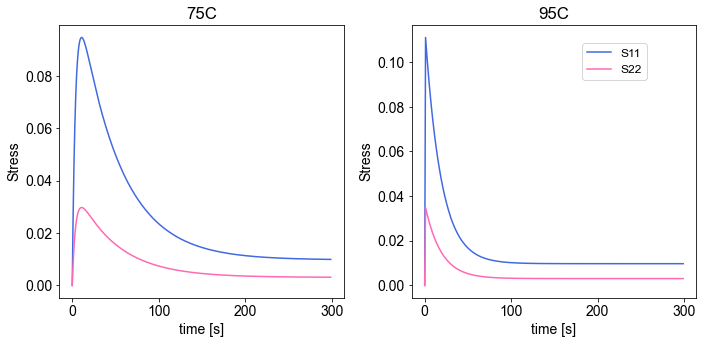

In [56]:
fig, axs = plt.subplots(1, 2,figsize=(10,5))
color_ls = np.linspace(0,1,8)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)
time_scatter = np.array([0.5e0,1e0,0.5e1,1e1,0.5e2,1e2])
axs[0].plot(frame_t[:-1],S11_vec[0,:-1],color='royalblue',label='S11')
axs[0].plot(frame_t[:-1],S22_vec[0,:-1],color='hotpink',label='S22')
axs[1].plot(frame_t[:-1],S11_vec[1,:-1],color='royalblue',label='S11')
axs[1].plot(frame_t[:-1],S22_vec[1,:-1],color='hotpink',label='S22')
#axs[0].set_xscale('log')
#axs[0].legend(loc=(0.6,0.4))
axs[0].set_title('75C')
axs[0].set_ylabel('Stress')
#axs[0].set_ylim((0.0,0.2))
axs[0].set_xlabel('time [s]')
#axs[1].set_xscale('log')
#axs[1].legend(loc=(0,1))
axs[1].set_title('95C')
axs[1].set_ylabel('Stress')
#axs[1].set_ylim((0.0,0.2))
axs[1].set_xlabel('time [s]')
axs[1].legend(loc=(0.6,0.8))
plt.tight_layout()
#plt.savefig('fig_isometric_3state.png',dpi=300)

In [57]:
# Same as for the two-state, we can do some parametric study 
# one parameter which makes sense, for the peak, is the mu_cc, the shear modulus of the coiled collagen
# the parameters that make sense for the decay are the kinetics parameters. The Ccmax for 75 will stay fixed at 0.8
# and the Cc max for 95 will stay at 1. But we can move along the kb curve in the phase space of Eab and Ab


time_final = 3e2 # sec 
dt = 0.1 #sec 
time_steps = int(time_final/dt)
n_frames = 300
frame_t = np.linspace(0,time_final,n_frames)
lamxp_vec = np.ones((nT,n_frames))
lamyp_vec = np.ones((nT,n_frames))

## Parameters that can be changed 
# coiled collagen 
mu_cc    = mu_co*0.036
beta_cc  = beta_co
delta_cc = delta_co
gama_cc  = gama_co*0.7
param_Cc = np.array([mu_cc,beta_cc,delta_cc,gama_cc])

# damaged collagen 
mu_cb    = mu_co*0.003
beta_cb  = beta_co
delta_cb = delta_co
gama_cb  = gama_co*0.7
param_Cb = np.array([mu_cb,beta_cb,delta_cb,gama_cb])


S11_ps_vec = np.zeros((4,2,n_frames))
S22_ps_vec = np.zeros((4,2,n_frames))

mucc_ps = [mu_co*0.03,mu_co*0.043,mu_co*0.036,mu_co*0.036]
Eab_ps = [0.5e5,0.5e5,0.5e5,0.5e5]
Ab_ps = [np.exp(np.log(kb_sol1)+0.5e5/R/(273+75)),np.exp(np.log(kb_sol1)+0.5e5/R/(273+75)),\
         np.exp(np.log(kb_sol0)+0.5e5/R/(273+75)),np.exp(np.log(kb_sol2)+0.5e5/R/(273+75))] 
# loop over temperature 
for ci in range(4):
    mucc_ci = mucc_ps[ci]
    param_Cc = np.array([mucc_ci,beta_cc,delta_cc,gama_cc])
    Eab_ci = 0.5e5
    Ab_ci = Ab_ps[ci]
    # loop over temperature 
    for i in range(2):
        T = T_vec_K_iso[i]
        # loop over time 
        time = 0
        # initialize the collagen concentrations in the different orientation 
        Co_theta = np.ones((len(rho_theta)))
        Cc_theta = np.zeros((len(rho_theta)))
        Cb_theta = np.zeros((len(rho_theta)))
        fi = 1
        for ti in range(0,time_steps):
            Co_theta = np.ones((ntheta))*Co_closed(time,k_c_param(T,3.57e5,1e53))
            Cc_theta = np.ones((ntheta))*Cc_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab_ci,Ab_ci))
            Cb_theta = np.ones((ntheta))*Cb_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab_ci,Ab_ci))
            time += dt
            #Ccdot = k_c(T)*Co_theta
            #Cbdot = k_b(T)*Cc_theta
            #Co_theta += -1.*dt*Ccdot
            #Cc_theta += dt*Ccdot - dt*Cbdot
            #Cb_theta += +1.*dt*Cbdot
            if time>=frame_t[fi]: 
                frame_dt = frame_t[fi]-frame_t[fi-1]
                # isometrix
                F = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])
                S = PK2_threestate(F,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
                S11_ps_vec[ci,i,fi] = S[0,0]
                S22_ps_vec[ci,i,fi] = S[1,1]
                fi+=1

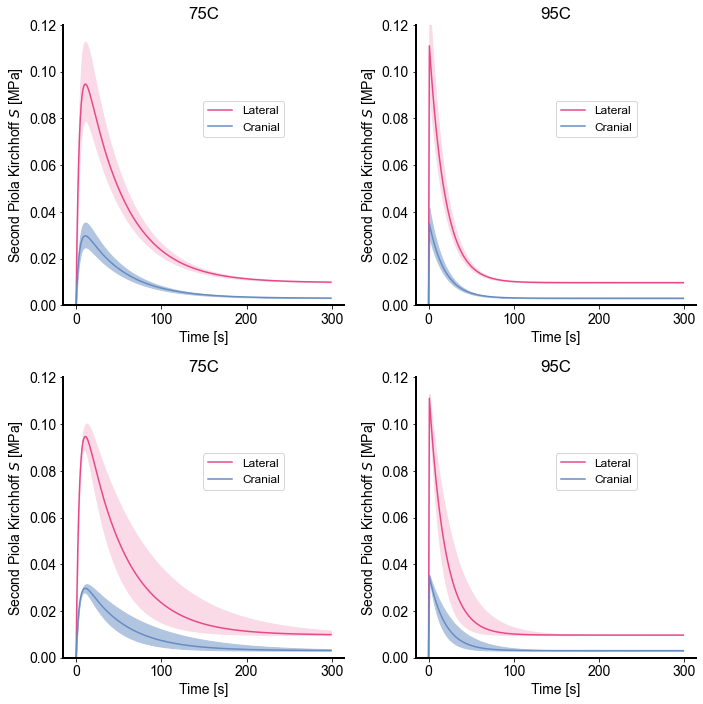

In [58]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
color_ls = np.linspace(0,1,8)
colors = [ cm.plasma(x) for x in color_ls ]
colors2 = [ cm.cool(x) for x in color_ls ]
#time_ls = np.linspace(0,time_final,n_frames)

# colors 
cp1 = [249/255,218/255,230/255]
cp2 = [231/255,73/255,136/255]
cb1 = [177/255,197/255,224/255]
cb2 = [103/255,140/255,194/255]

# plotting beta cases for the same tau 
# 75
axs[0,0].fill_between(frame_t[:-1],S11_ps_vec[0,0,:-1],S11_ps_vec[1,0,:-1],color=cp1)
axs[0,0].fill_between(frame_t[:-1],S22_ps_vec[0,0,:-1],S22_ps_vec[1,0,:-1],color=cb1)
axs[0,0].plot(frame_t[:-1],S11_vec[0,:-1],color=cp2,label='Lateral')
axs[0,0].plot(frame_t[:-1],S22_vec[0,:-1],color=cb2,label='Cranial')
# 95
axs[0,1].fill_between(frame_t[:-1],S11_ps_vec[0,1,:-1],S11_ps_vec[1,1,:-1],color=cp1)
axs[0,1].fill_between(frame_t[:-1],S22_ps_vec[0,1,:-1],S22_ps_vec[1,1,:-1],color=cb1)
axs[0,1].plot(frame_t[:-1],S11_vec[1,:-1],color=cp2,label='Lateral')
axs[0,1].plot(frame_t[:-1],S22_vec[1,:-1],color=cb2,label='Cranial')
# plotting beta cases for the same beta
# 75
axs[1,0].fill_between(frame_t[:-1],S11_ps_vec[2,0,:-1],S11_ps_vec[3,0,:-1],color=cp1)
axs[1,0].fill_between(frame_t[:-1],S22_ps_vec[2,0,:-1],S22_ps_vec[3,0,:-1],color=cb1)
axs[1,0].plot(frame_t[:-1],S11_vec[0,:-1],color=cp2,label='Lateral')
axs[1,0].plot(frame_t[:-1],S22_vec[0,:-1],color=cb2,label='Cranial')
# 95
axs[1,1].fill_between(frame_t[:-1],S11_ps_vec[2,1,:-1],S11_ps_vec[3,1,:-1],color=cp1)
axs[1,1].fill_between(frame_t[:-1],S22_ps_vec[2,1,:-1],S22_ps_vec[3,1,:-1],color=cb1)
axs[1,1].plot(frame_t[:-1],S11_vec[1,:-1],color=cp2,label='Lateral')
axs[1,1].plot(frame_t[:-1],S22_vec[1,:-1],color=cb2,label='Cranial')

#
axs[0,0].set_title(r'75C')
axs[0,1].set_title(r'95C')
axs[1,0].set_title(r'75C')
axs[1,1].set_title(r'95C')
for ai in range(2):
    for aj in range(2):
        axs[ai,aj].set_ylabel(r'Second Piola Kirchhoff $S$ [MPa]')
        axs[ai,aj].set_ylim((0.0,0.12))
        axs[ai,aj].set_xlabel('Time [s]')
        axs[ai,aj].spines['bottom'].set_linewidth(2)
        axs[ai,aj].spines['left'].set_linewidth(2)
        axs[ai,aj].spines['right'].set_visible(False)
        axs[ai,aj].spines['top'].set_visible(False)
        axs[ai,aj].legend(loc=(0.5,0.6))

plt.tight_layout()
plt.savefig('fig_isometric_ps_3state.png',dpi=300)

## Biaxial properties after denaturation 

### Two-state model 

In [59]:
time_final = 10 # sec 
dt = 0.05 #sec 
time_steps = int(time_final/dt)


# parameters for the denatured collagen 
# denatured collagen 
mu_cd    = mu_co*0.003
gama_cd  = gama_co*0.7
# beta controls the viscosity branch relative to equilibrium branch
beta_visc= 10
# tau controls the time scale of relaxation 
tau_visc = 50 # [s]
#
param_Cd = np.array([mu_cd,beta_cd,delta_cd,gama_cd,beta_visc,tau_visc])

nlam = 20
lamx_ls = np.linspace(1,1.1,nlam)
lamy_ls = np.linspace(1,1.2,nlam)
S2state_ls = np.zeros((1,nlam,2))
dt_biaxial = 0.025

# loop over temperature 
T_vec_K_bi = [90+273]
for i in range(1):
    T = T_vec_K_bi[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cd_theta = np.zeros((len(rho_theta)))
    # initialize the viscoelastic response 
    I4v_theta_n = np.ones((len(rho_theta)))
    I4v_theta = np.ones((len(rho_theta)))
    kd = k_d(T)
    lamxp = 1.0
    lamyp = 1.0
    for ti in range(0,time_steps):
        Cd_theta_t = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta_t = Co_closed(time,kd)*np.ones((ntheta))
        time += dt 
        Cd_theta = Cd_closed(time,kd)*np.ones((ntheta))
        Co_theta = Co_closed(time,kd)*np.ones((ntheta))
        #Cddot = k_d(T)*Co_theta
        #Co_theta += -1.*dt*k_d(T)*Co_theta
        Cdnorm = Cd_theta_t/Cd_theta
        I4v_theta_n = Cdnorm*I4v_theta_n+(1-Cdnorm)
        resnorm = 1
        tol = 1e-4
        iter=0
        itermax = 60
        Res = np.zeros((2))
        dRes = np.zeros((2,2))
        while iter<itermax and resnorm>tol:
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            S,I4v_new = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,dt)
            Res[0] = S[0,0]
            Res[1] = S[1,1]
            lamxp += 1e-6
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            Sp, aux = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,dt)
            dRes[0,0] = (Sp[0,0]-S[0,0])/1e-6
            dRes[1,0] = (Sp[1,1]-S[1,1])/1e-6
            lamxp -= 1e-6
            lamyp += 1e-6
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            Sp, aux = PK2_twostate(Fp,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta_n,dt)
            dRes[0,1] = (Sp[0,0]-S[0,0])/1e-6
            dRes[1,1] = (Sp[1,1]-S[1,1])/1e-6
            lamyp -= 1e-6
            dlamp = np.linalg.solve(dRes,Res)
            lamxp -= dlamp[0]
            lamyp -= dlamp[1]
            iter +=1
            resnorm = np.linalg.norm(Res)
        #print('iter ',iter,' resnorm ',resnorm)
        I4v_theta = I4v_new
        I4v_theta_n = I4v_new
        #print(I4v_theta)
        if iter==itermax:
            break
        # lamxp has the pre-stretch in one direction
        # lamyp has the pre-stretch in the other direction 
    print('prestrain after 10sec of denaturation')
    Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
    print(Fp)
    print('denatured collagen')
    print(Cd_theta)
    print('viscosity ')
    print(I4v_theta)
I4v_prestrain = np.zeros((ntheta))
I4v_prestrain = I4v_theta


prestrain after 10sec of denaturation
[[0.78424864 0.         0.        ]
 [0.         0.8427466  0.        ]
 [0.         0.         1.51303584]]
denatured collagen
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
viscosity 
[1.02816608 1.02810221 1.02791196 1.02759937 1.027171   1.02663567
 1.0260042  1.02528897 1.02450361 1.02366254 1.02278061 1.02187279
 1.02095388 1.02003823 1.01913966 1.01827124 1.01744527 1.01667317
 1.01596546 1.01533165 1.01478025 1.01431863 1.01395297 1.01368821
 1.0135279  1.01347422 1.0135279  1.01368821 1.01395297 1.01431863
 1.01478025 1.01533165 1.01596546 1.01667317 1.01744527 1.01827124
 1.01913966 1.02003823 1.02095388 1.02187279 1.02278061 1.02366254
 1.02450361 1.02528897 1.0260042  1.02663567 1.027171   1.02759937
 1.02791196 1.02810221 1.02816608]


In [60]:
# Now do biaxial test 
nlam = 20
lamx_ls = np.linspace(1,1.18,nlam)
lamy_ls = np.linspace(1,1.28,nlam)
S2state_ls = np.zeros((1,nlam,2))
dt_biaxial = 0.1
# time integration 
I4v_theta = I4v_prestrain
#I4v_theta = np.ones((len(rho_theta)))
for si in range(nlam):
    lamx = lamx_ls[si]
    lamy = lamy_ls[si]
    F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
    Ftot = np.dot(F,Fp)
    # note, I4v_theta from previous time is passed, and update is an output, no pass by reference
    S,I4vnew = PK2_twostate(Ftot,param_Co,param_Cd,rho_theta,Co_theta,Cd_theta,I4v_theta,dt_biaxial)
    I4v_theta = I4vnew
    S2state_ls[0,si,0] = S[0,0]
    S2state_ls[0,si,1] = S[1,1]

In [61]:
# Native for comparison
Snative_ls = np.zeros((nlam,2))
lamx_n_ls = np.linspace(1,1.1,nlam)
lamy_n_ls = np.linspace(1,1.2,nlam)
for i in range(nlam):
    lamx = lamx_n_ls[i]
    lamy = lamy_n_ls[i]
    F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
    S = PK2_native(F,param_Co,rho_theta)
    Snative_ls[i,0] = S[0,0]
    Snative_ls[i,1] = S[1,1]

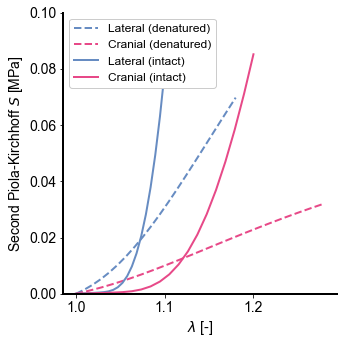

In [62]:
fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(lamx_ls,S2state_ls[0,:,0],color=cb2,linestyle='--',linewidth=2,label='Lateral (denatured)')
axs.plot(lamy_ls,S2state_ls[0,:,1],color=cp2,linestyle='--',linewidth=2,label='Cranial (denatured)')
axs.plot(lamx_n_ls,Snative_ls[:,0],color=cb2,linestyle='-',label='Lateral (intact)',linewidth=2)
axs.plot(lamy_n_ls,Snative_ls[:,1],color=cp2,linestyle='-',label='Cranial (intact)',linewidth=2)
#axs.set_title('Biaxial after 90C for 10s, two-state')
axs.set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
axs.set_xlabel(r'$\lambda$ [-]')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_linewidth(2)
axs.spines['left'].set_linewidth(2)
axs.set_ylim((0,0.10))
axs.legend(loc=2,framealpha=1)
# Used to have two temperatures, but to match the paper 1 I changed to 1 temperature 
# axs[1].plot(lamx_ls,S2state_ls[1,:,0],color='royalblue',linestyle='--',linewidth=2)
# axs[1].plot(lamy_ls,S2state_ls[1,:,1],color='hotpink',linestyle='--',linewidth=2)
# axs[1].plot(lamx_ls,Snative_ls[:,0],color='royalblue',linestyle='-',label='Lateral',linewidth=2)
# axs[1].plot(lamy_ls,Snative_ls[:,1],color='hotpink',linestyle='-',label='Cranial-caudal',linewidth=2)
# axs[1].set_title('Biaxial response after 95C for 10s')
# axs[1].set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
# axs[1].set_xlabel(r'$\lambda$ [-]')
# axs[1].spines['right'].set_visible(False)
# axs[1].spines['top'].set_visible(False)
# axs[1].spines['bottom'].set_linewidth(2)
# axs[1].spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig('biaxial_2state_90C10s.png',dpi=300)

### Three state model

In [63]:
time_final = 10 # sec 
dt = 0.05 #sec 
time_steps = int(time_final/dt)

nlam = 20
lamx_ls = np.linspace(1,1.18,nlam)
lamy_ls = np.linspace(1,1.28,nlam)
S3state_ls = np.zeros((1,nlam,2))

# loop over temperature 
T_vec_K_bi = [90+273]

## Parameters that can be changed 
# coiled collagen 
mu_cc    = mu_co*0.036
beta_cc  = beta_co
delta_cc = delta_co
gama_cc  = gama_co*0.7
param_Cc = np.array([mu_cc,beta_cc,delta_cc,gama_cc])

# damaged collagen 
mu_cb    = mu_co*0.003
beta_cb  = beta_co
delta_cb = delta_co
gama_cb  = gama_co*0.7
param_Cb = np.array([mu_cb,beta_cb,delta_cb,gama_cb])

# loop over temperature 
Eab = 0.5e5
Ab = np.exp(np.log(kb_sol1)+0.5e5/R/(273+75))
for i in range(1):
    T = T_vec_K_bi[i]
    # loop over time 
    time = 0
    # initialize the collagen concentrations in the different orientation 
    Co_theta = np.ones((len(rho_theta)))
    Cc_theta = np.zeros((len(rho_theta)))
    Cb_theta = np.zeros((len(rho_theta)))
    lamxp = 1.0
    lamyp = 1.0
    for ti in range(0,time_steps):
        Co_theta = np.ones((ntheta))*Co_closed(time,k_c_param(T,3.57e5,1e53))
        Cc_theta = np.ones((ntheta))*Cc_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        Cb_theta = np.ones((ntheta))*Cb_closed(time,k_c_param(T,3.57e5,1e53),k_b_param(T,Eab,Ab))
        time += dt
        #Ccdot = k_c(T)*Co_theta
        #Cbdot = k_b(T)*Cc_theta
        #Co_theta += -1.*dt*Ccdot
        #Cc_theta += dt*Ccdot - dt*Cbdot
        #Cb_theta += +1.*dt*Cbdot

        # need to unload so that we recover zero in x and y 
        resnorm = 1
        tol = 1e-4
        iter=0
        itermax = 60
        Res = np.zeros((2))
        dRes = np.zeros((2,2))
        while iter<itermax and resnorm>tol:
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            S = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
            Res[0] = S[0,0]
            Res[1] = S[1,1]
            lamxp += 1e-6
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            Sp = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
            dRes[0,0] = (Sp[0,0]-S[0,0])/1e-6
            dRes[1,0] = (Sp[1,1]-S[1,1])/1e-6
            lamxp -= 1e-6
            lamyp += 1e-6
            Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
            Sp = PK2_threestate(Fp,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
            dRes[0,1] = (Sp[0,0]-S[0,0])/1e-6
            dRes[1,1] = (Sp[1,1]-S[1,1])/1e-6
            lamyp -= 1e-6
            dlamp = np.linalg.solve(dRes,Res)
            lamxp -= dlamp[0]
            lamyp -= dlamp[1]
            iter +=1
            resnorm = np.linalg.norm(Res)
        if iter==itermax:
            break
        #lamxp_vec[i,fi] = lamxp
        #lamyp_vec[i,fi] = lamyp
    print('prestrain at end of 10 sec')
    Fp = np.array([[lamxp,0,0],[0,lamyp,0],[0,0,1./(lamxp*lamyp)]])
    print(Fp)
    print('concentration of coiled collagen')
    print(Cc_theta)
    # Now do biaxial test 
    # time integration 
    for si in range(nlam):
        lamx = lamx_ls[si]
        lamy = lamy_ls[si]
        
        F = np.array([[lamx,0,0],[0,lamy,0],[0,0,1./(lamx*lamy)]])
        Ftot = np.dot(F,Fp)
        S = PK2_threestate(Ftot,param_Co,param_Cc,param_Cb,rho_theta,Co_theta,Cc_theta,Cb_theta)
        S3state_ls[i,si,0] = S[0,0]
        S3state_ls[i,si,1] = S[1,1]

prestrain at end of 10 sec
[[0.78482594 0.         0.        ]
 [0.         0.84332342 0.        ]
 [0.         0.         1.51088875]]
concentration of coiled collagen
[0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136 0.64904136
 0.64904136 0.64904136 0.64904136]


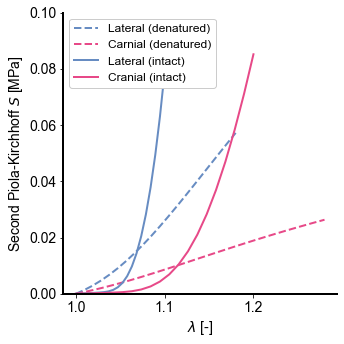

In [64]:
fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(lamx_ls,S3state_ls[0,:,0],color=cb2,linestyle='--',linewidth=2,label='Lateral (denatured)')
axs.plot(lamy_ls,S3state_ls[0,:,1],color=cp2,linestyle='--',linewidth=2,label='Carnial (denatured)')
axs.plot(lamx_n_ls,Snative_ls[:,0],color=cb2,linestyle='-',label='Lateral (intact)',linewidth=2)
axs.plot(lamy_n_ls,Snative_ls[:,1],color=cp2,linestyle='-',label='Cranial (intact)',linewidth=2)
#axs.set_title('Biaxial after 90C for 10s: three-state')
axs.set_ylabel(r'Second Piola-Kirchhoff $S$ [MPa]')
axs.set_xlabel(r'$\lambda$ [-]')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['bottom'].set_linewidth(2)
axs.spines['left'].set_linewidth(2)
axs.set_ylim((0,0.10))
axs.legend(loc=2,framealpha=1)
plt.tight_layout()
plt.savefig('biaxial_3state_90C10s.png',dpi=300)